<h1 style="text-align:center; color: #1E90FF;"> HAHAHAHAHAHAHAH </h1>


# Import libraries

In [ ]:
from collections import Counter
from pathlib import Path

# Bibliothèques pour visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliothèques pour le traitement de texte et données
import nltk
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from wordcloud import WordCloud
import ast
import re
# import pyLDAvis
# import pyLDAvis.lda_model
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import TfidfVectorizer

# Charger les bibliothèques statistiques
from statsmodels.stats import diagnostic
from scipy import stats
import scipy.stats as stats

# Activer autoreload pour recharger automatiquement les modules modifiés
%load_ext autoreload
%autoreload 2


# we will need some ntlk dependencies
nltk.download(['stopwords', 'wordnet', 'punkt_tab'])



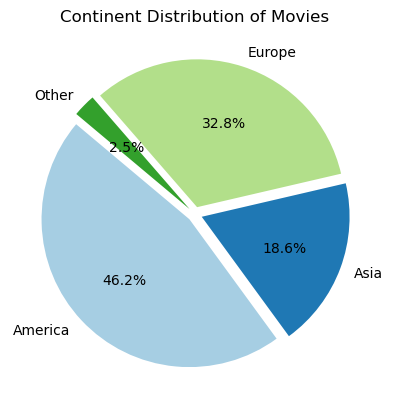
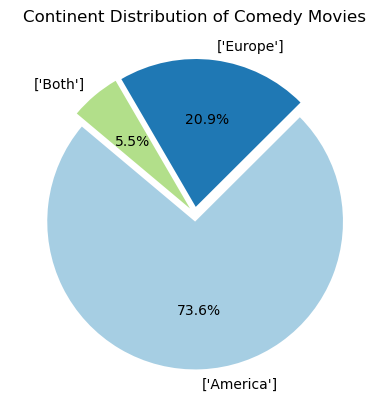

# Preprocessing the Data (building the final DataFrame)

## CMU Movie Summary Corpus

In [7]:

# Define the file paths
plot_summaries_path = 'Data/MovieSummaries.nosync/plot_summaries.txt'
movie_metadata_path = 'Data/MovieSummaries.nosync/movie.metadata.tsv'
character_metadata_path = 'Data/MovieSummaries.nosync/character.metadata.tsv'

# Load plot summaries
plot_summaries = pd.read_csv(plot_summaries_path, sep='\t', header=None, names=['Wikipedia_ID', 'Plot_Summary'])

# Load movie metadata
movie_metadata = pd.read_csv(movie_metadata_path, sep='\t', header=None, names=['Wikipedia_ID', 'Freebase_ID', 'Movie_Name', 'Release_Date', 'Box_Office_Revenue', 'Runtime', 'Languages', 'Countries', 'Genres'])

# Load character metadata
character_metadata = pd.read_csv(character_metadata_path, sep='\t', header=None, names=['Wikipedia_ID', 'Freebase_ID', 'Release_Date', 'Character_Name', 'Actor_Birth_Date', 'Actor_Gender', 'Actor_Height', 'Actor_Ethnicity', 'Actor_Name', 'Actor_Age', 'Character_Actor_Freebase_ID', 'Character_Freebase_ID', 'Actor_Freebase_ID'])

display(movie_metadata.head(3) , movie_metadata.shape)



,Wikipedia_ID,Freebase_ID,Movie_Name,Release_Date,Box_Office_Revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


(81741, 9)

### Treatment colomns Languages, Countries and Genres
The code loads a CSV file with movie metadata into a DataFrame, defining names for each column. The "Freebase_ID" column is removed, and the "Languages," "Countries," and "Genres" columns are converted into lists of values by extracting data from dictionary-like strings. Empty cells are replaced with "Unknown." Finally, the first few rows of the DataFrame are displayed for verification.

In [8]:
# Load movie metadata
movie_metadata = pd.read_csv(movie_metadata_path, sep='\t', header=None, names=['Wikipedia_ID', 'Freebase_ID', 'Movie_Name', 'Release_Date', 'Box_Office_Revenue', 'Runtime', 'Languages', 'Countries', 'Genres'])

movie_metadata = movie_metadata.drop(columns=['Freebase_ID'], inplace=False)

# Explode the 'Languages' column
movie_metadata['Languages'] = movie_metadata['Languages'].apply(lambda x: list(eval(x).values()) if x != '{}' else ['Unknown'])

# Explode the 'Countries' column
movie_metadata['Countries'] = movie_metadata['Countries'].apply(lambda x: list(eval(x).values()) if x != '{}' else ['Unknown'])

# Explode the 'Genres' column
movie_metadata['Genres'] = movie_metadata['Genres'].apply(lambda x: list(eval(x).values()) if x != '{}' else ['Unknown'])


### Mapping Countries to Continents and Filtering for America and Europe

This code defines a dictionary to classify countries by continent, then uses a function to map each country to its respective continent. If a country does not match any defined continent, it is labeled as "Other." This mapping function is applied to the "Countries" column in the `movie_metadata` DataFrame to create a new column, "Continents." Finally, the DataFrame is filtered to retain only rows where the continent includes "America" or "Europe".

In [9]:
from src.utils.data_utils import map_country_list_to_continent

# Apply the mapping function to the 'Countries' column
movie_metadata['Continents'] = movie_metadata['Countries'].apply(lambda x: map_country_list_to_continent(x))

# Filter rows where 'Continents' contains 'America' or 'Europe'
movie_metadata = movie_metadata[movie_metadata['Continents'].apply(lambda x: 'America' in x or 'Europe' in x)]

In [10]:
from src.utils.data_utils import treat_continent

movie_metadata["Continents"] = movie_metadata["Continents"].apply(lambda x: treat_continent(x))

# Remove rows where the continent list size is greater than or equal to 3
movie_metadata = movie_metadata[movie_metadata["Continents"].apply(lambda x: len(x) < 3)]

# Display the updated value counts for the 'Continents' column
display(movie_metadata["Continents"].value_counts())

    

Continents
[America]             34779
[Europe]              18488
[Both]                 3000
[America, Asia]         456
[Europe, Asia]          366
[Europe, Africa]        195
[America, Oceania]      182
[Both, Asia]            130
[Europe, Oceania]        93
[America, Africa]        63
[Both, Oceania]          50
[Both, Africa]           35
Name: count, dtype: int64

### Filtering for Comedy Genre and Counting Occurrences

This code filters the movies to keep only those with the genre "Comedy." It sets other genres to `None`, then drops rows without "Comedy" in the "Genres" column. 

In [11]:

movie_metadata["Genres"] = movie_metadata["Genres"].apply(lambda x: x if 'Comedy' in x else None)

movie_metadata = movie_metadata.dropna(subset=["Genres"])

movie_metadata["Genres"].value_counts()
    

Genres
[Comedy]                                                                           1700
[Short Film, Silent film, Indie, Black-and-white, Comedy]                           547
[Drama, Comedy]                                                                     358
[Short Film, Comedy, Black-and-white]                                               252
[Comedy, Black-and-white]                                                           250
                                                                                   ... 
[Silent film, Melodrama, Indie, Comedy-drama, Black-and-white, Comedy]                1
[LGBT, Gay Interest, Indie, Gay, Satire, Comedy, Gay Themed, Romance Film]            1
[LGBT, Horror, Comedy-drama, Psychological thriller, Comedy, Black comedy]            1
[Period piece, Drama, Comedy, Film adaptation, Black comedy, Biographical film]       1
[Crime Fiction, Thriller, Comedy, Supernatural]                                       1
Name: count, Length: 6092

### Filling Missing Box Office Values and Verifying Changes


This code fills any `NaN` values in the "Box_Office_Revenue" column with 0. Then, it displays the first few rows and the shape of the DataFrame to verify the changes.

In [12]:
# Remplir les valeurs NaN de la colonne Box_Office_Revenue par 0
movie_metadata['Box_Office_Revenue'] = movie_metadata['Box_Office_Revenue'].fillna(0)

## Open Movie Database (OMBD)

In [13]:
# Load the OMDB API data
omdb_data_path = 'Data/MovieSummaries.nosync/movies_omdbapi.csv'
omdb_data = pd.read_csv(omdb_data_path)

# Display the first few rows of the dataframe
display(omdb_data.head(), omdb_data.shape)

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,totalSeasons
0,Ghosts of Mars,2001,R,24 Aug 2001,98 min,"Action, Horror, Sci-Fi",John Carpenter,"Larry Sulkis, John Carpenter","Natasha Henstridge, Ice Cube, Pam Grier","In 2176, a Martian police unit is sent to pick...",...,4.9,"58,722",tt0228333,movie,NaN,"$8,709,640",NaN,NaN,True,NaN
1,Getting Away with Murder: The JonBenet Ramsey ...,2000,NaN,16 Feb 2000,95 min,Drama,Edward Lucas,"Michael A. Graham, Ted Haimes","Alice Barrett, Rod Britt, Hildy Brooks","Six-year-old JonBenét Ramsey, whose body was f...",...,6.0,69,tt0245916,movie,NaN,NaN,NaN,NaN,True,NaN
2,Brun bitter,1988,NaN,17 Nov 1988,83 min,"Crime, Drama",Sølve Skagen,"Sølve Skagen, Gunnar Staalesen","Frank Krog, Kristin Kajander, Anne Krigsvoll","The lonely, divorced and disillusioned lawyer ...",...,5.8,40,tt0094806,movie,NaN,NaN,NaN,NaN,True,NaN
3,White of the Eye,1987,R,19 Jun 1987,110 min,"Horror, Mystery, Thriller",Donald Cammell,"China Kong, Donald Cammell, Andrew Klavan","David Keith, Cathy Moriarty, Alan Rosenberg",Somebody's killing rich married women in their...,...,6.1,"3,071",tt0094320,movie,NaN,"$225,132",NaN,NaN,True,NaN
4,A Woman in Flames,1983,Not Rated,10 Jun 1983,106 min,Drama,Robert van Ackeren,"Robert van Ackeren, Catharina Zwerenz","Gudrun Landgrebe, Mathieu Carrière, Hanns Zisc...","Eva, an upper-class housewife, frustratingly l...",...,5.9,648,tt0083949,movie,NaN,NaN,NaN,NaN,True,NaN


(71544, 26)

In [14]:
omdb_data = pd.read_csv(omdb_data_path)
print(omdb_data.columns)
display(omdb_data.head())

Index(['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director',
       'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster',
       'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type',
       'DVD', 'BoxOffice', 'Production', 'Website', 'Response',
       'totalSeasons'],
      dtype='object')


,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,totalSeasons
0,Ghosts of Mars,2001,R,24 Aug 2001,98 min,"Action, Horror, Sci-Fi",John Carpenter,"Larry Sulkis, John Carpenter","Natasha Henstridge, Ice Cube, Pam Grier","In 2176, a Martian police unit is sent to pick...",...,4.9,"58,722",tt0228333,movie,NaN,"$8,709,640",NaN,NaN,True,NaN
1,Getting Away with Murder: The JonBenet Ramsey ...,2000,NaN,16 Feb 2000,95 min,Drama,Edward Lucas,"Michael A. Graham, Ted Haimes","Alice Barrett, Rod Britt, Hildy Brooks","Six-year-old JonBenét Ramsey, whose body was f...",...,6.0,69,tt0245916,movie,NaN,NaN,NaN,NaN,True,NaN
2,Brun bitter,1988,NaN,17 Nov 1988,83 min,"Crime, Drama",Sølve Skagen,"Sølve Skagen, Gunnar Staalesen","Frank Krog, Kristin Kajander, Anne Krigsvoll","The lonely, divorced and disillusioned lawyer ...",...,5.8,40,tt0094806,movie,NaN,NaN,NaN,NaN,True,NaN
3,White of the Eye,1987,R,19 Jun 1987,110 min,"Horror, Mystery, Thriller",Donald Cammell,"China Kong, Donald Cammell, Andrew Klavan","David Keith, Cathy Moriarty, Alan Rosenberg",Somebody's killing rich married women in their...,...,6.1,"3,071",tt0094320,movie,NaN,"$225,132",NaN,NaN,True,NaN
4,A Woman in Flames,1983,Not Rated,10 Jun 1983,106 min,Drama,Robert van Ackeren,"Robert van Ackeren, Catharina Zwerenz","Gudrun Landgrebe, Mathieu Carrière, Hanns Zisc...","Eva, an upper-class housewife, frustratingly l...",...,5.9,648,tt0083949,movie,NaN,NaN,NaN,NaN,True,NaN


## Merging DataFrames and Dropping Unnecessary Columns

This code merges two DataFrames, movie_metadata and omdb_data, using an inner join on the "Movie_Name" column from movie_metadata and the "Title" column from omdb_data.Afterward, it removes unneeded columns ("Released," "Genre," "Title," "Language," "Country," and "Type") to keep only relevant information.

In [15]:
# Merge the two dataframes on the 'Movie_Name' column
merged_movie_metadata = pd.merge(movie_metadata, omdb_data, left_on='Movie_Name', right_on='Title', how='inner')
# Drop columns
merged_movie_metadata = merged_movie_metadata.drop(columns=["Released" , "Genre" , "Title" , "Language" , "Country" ,"Type"])

### Cleaning and Merging Box Office Revenue Data

This code combines revenue data from "Box_Office_Revenue" and "BoxOffice" to ensure complete, consistent values. It removes the dollar sign from "BoxOffice," converts it to a float, replaces 0s in "Box_Office_Revenue" with `NaN`, and fills missing values from "BoxOffice." The "BoxOffice" column is then dropped, leaving a unified "Box_Office_Revenue" column in float format. This process standardizes revenue data for further analysis.

In [16]:
# Merge box office revenue columns
display(merged_movie_metadata[["Box_Office_Revenue","BoxOffice"]].head())

# Merge box office revenue columns
# Remove the '$' sign and convert the 'BoxOffice' column to float
merged_movie_metadata['BoxOffice'] = merged_movie_metadata['BoxOffice'].replace('[\$,]', '', regex=True).astype(float)

# Replace 0 values in 'Box_Office_Revenue' with NaN
merged_movie_metadata['Box_Office_Revenue'].replace(0, pd.NA, inplace=True)

# Fill missing values in 'Box_Office_Revenue' with values from 'BoxOffice'
merged_movie_metadata['Box_Office_Revenue'] = merged_movie_metadata['Box_Office_Revenue'].fillna(merged_movie_metadata['BoxOffice'])

# Drop the 'BoxOffice' column as it is now merged
merged_movie_metadata = merged_movie_metadata.drop(columns=['BoxOffice'])

# Display the first few rows to verify the changes
display(merged_movie_metadata[['Box_Office_Revenue']].head())


display(merged_movie_metadata["Box_Office_Revenue"].isna().sum())
# Verify if the 'Box_Office_Revenue' column contains only floats
is_float = merged_movie_metadata['Box_Office_Revenue'].apply(lambda x: isinstance(x, float)).all()
print(f"All values in 'Box_Office_Revenue' are floats: {is_float}")


,Box_Office_Revenue,BoxOffice
0,0.0,NaN
1,3600000.0,NaN
2,0.0,NaN
3,102272727.0,"$102,272,727"
4,0.0,"$69,171"


/var/folders/w1/f3785wtj77166md17d9fj02w0000gn/T/ipykernel_49108/884545400.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_movie_metadata['Box_Office_Revenue'].replace(0, pd.NA, inplace=True)
/var/folders/w1/f3785wtj77166md17d9fj02w0000gn/T/ipykernel_49108/884545400.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

,Box_Office_Revenue
0,NaN
1,3600000.0
2,NaN
3,102272727.0
4,69171.0


8429

All values in 'Box_Office_Revenue' are floats: True


### Cleaning and Merging Runtime Data

This code standardizes the runtime data by removing unwanted characters and combining columns. First, digits are removed from "Runtime_y" to identify common patterns, and rows with invalid characters ('h' or 'S') are filtered out. The column is further cleaned by stripping "min" and converting values to float. Any missing values in "Runtime_x" are then filled using "Runtime_y," after which "Runtime_y" is dropped. Finally, "Runtime_x" is renamed to "Runtime" for clarity, ensuring all runtime data is consolidated and ready for analysis.

In [17]:
# Remove digits from the 'Runtime_y' column
runtime_counts = merged_movie_metadata['Runtime_y'].str.replace('\d+', '', regex=True).value_counts()

# Display the result
print(runtime_counts)

# Remove rows containing 'h' or 'S' in the 'Runtime_y' column
merged_movie_metadata = merged_movie_metadata[~merged_movie_metadata['Runtime_y'].str.contains('h|S', na=False)]

# Display the first few rows to verify the changes
display(merged_movie_metadata[['Runtime_y']].head())

# Remove digits from the 'Runtime_y' column
runtime_counts = merged_movie_metadata['Runtime_y'].str.replace('\d+', '', regex=True).value_counts()

# Display the result
print(runtime_counts)

Runtime_y
 min       13330
S min         31
 h  min        5
 h             1
Name: count, dtype: int64


,Runtime_y
0,105 min
1,106 min
2,70 min
3,139 min
4,83 min


Runtime_y
min    13330
Name: count, dtype: int64


In [ ]:
# Merge runtime columns
# Remove 'min' from 'Runtime_y' and convert to float
merged_movie_metadata['Runtime_y'] = merged_movie_metadata['Runtime_y'].str.replace(' min', '').astype(float)

# Replace NaN values in 'Runtime_x' with values from 'Runtime_y'
merged_movie_metadata['Runtime_x'].fillna(merged_movie_metadata['Runtime_y'], inplace=True)

# Drop the 'Runtime_y' column as it is now merged
merged_movie_metadata = merged_movie_metadata.drop(columns=['Runtime_y'])

# Rename 'Runtime_x' to 'Runtime'
merged_movie_metadata.rename(columns={'Runtime_x': 'Runtime'}, inplace=True)



### Extracting and Organizing Ratings Data


This code extracts individual ratings from a JSON-like "Ratings" column. It defines a function to parse `ratings_str`, converting it to a dictionary of ratings by source (e.g., IMDb, Rotten Tomatoes). This function is applied to create a "Ratings_Dict" column, from which specific ratings are extracted into separate columns: "Internet_Movie_Database_Rating," "Rotten_Tomatoes_Rating," and "Metacritic_Rating." 

In [19]:
from src.utils.data_utils import extract_awards

# Apply the function to the Awards column and create new columns
merged_movie_metadata[['Oscar', 'Nomination_Awards', 'Win_Awards']] = merged_movie_metadata['Awards'].apply(lambda x: pd.Series(extract_awards(x)))


### Extracting, Normalizing, and Verifying Ratings Data



This code extracts and standardizes movie ratings to a 10-point scale. Initially, it parses the "Ratings" column to create a dictionary of ratings by source (IMDb, Rotten Tomatoes, Metacritic). Each rating source is extracted into separate columns, and a function then normalizes the values to a scale of 10, converting percentages and different scales as needed. The transformed columns are verified to ensure all values are floats and below 10, confirming the consistency of the rating data for analysis.

In [20]:
from src.utils.data_utils import extract_ratings

# Apply the function to the Ratings column
merged_movie_metadata['Ratings_Dict'] = merged_movie_metadata['Ratings'].apply(extract_ratings)

# Extract ratings from different sources
merged_movie_metadata['Internet_Movie_Database_Rating'] = merged_movie_metadata['Ratings_Dict'].apply(lambda x: x.get('Internet Movie Database', None))
merged_movie_metadata['Rotten_Tomatoes_Rating'] = merged_movie_metadata['Ratings_Dict'].apply(lambda x: x.get('Rotten Tomatoes', None))
merged_movie_metadata['Metacritic_Rating'] = merged_movie_metadata['Ratings_Dict'].apply(lambda x: x.get('Metacritic', None))

# Drop the temporary Ratings_Dict column
merged_movie_metadata = merged_movie_metadata.drop(columns=['Ratings_Dict'])

# Display the first few rows to verify the changes
display(merged_movie_metadata[['Movie_Name', 'Internet_Movie_Database_Rating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating']].head())


,Movie_Name,Internet_Movie_Database_Rating,Rotten_Tomatoes_Rating,Metacritic_Rating
0,The Gangsters,5.9/10,None,None
1,Alexander's Ragtime Band,6.8/10,83%,None
2,Contigo y aquí,None,None,None
3,Mary Poppins,7.8/10,97%,88/100
4,White on Rice,6.1/10,45%,45/100


In [21]:
from src.utils.data_utils import convert_to_scale_of_10

# Apply the function to the rating columns
merged_movie_metadata['Internet_Movie_Database_Rating'] = merged_movie_metadata['Internet_Movie_Database_Rating'].apply(convert_to_scale_of_10)
merged_movie_metadata['Rotten_Tomatoes_Rating'] = merged_movie_metadata['Rotten_Tomatoes_Rating'].apply(convert_to_scale_of_10)
merged_movie_metadata['Metacritic_Rating'] = merged_movie_metadata['Metacritic_Rating'].apply(convert_to_scale_of_10)


In [22]:
merged_movie_metadata['Metacritic_Rating'] = merged_movie_metadata['Metacritic_Rating'] / 100
# Display the first few rows to verify the changes
display(merged_movie_metadata[['Movie_Name', 'Internet_Movie_Database_Rating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating']].head())


,Movie_Name,Internet_Movie_Database_Rating,Rotten_Tomatoes_Rating,Metacritic_Rating
0,The Gangsters,5.9,NaN,NaN
1,Alexander's Ragtime Band,6.8,8.3,NaN
2,Contigo y aquí,NaN,NaN,NaN
3,Mary Poppins,7.8,9.7,8.8
4,White on Rice,6.1,4.5,4.5


In [23]:

# Verify that the columns contain only numbers less than 10 and are floats
columns_to_check = ['Internet_Movie_Database_Rating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating']
for column in columns_to_check:
    all_less_than_10 = merged_movie_metadata[column].apply(lambda x: x <= 10 if pd.notna(x) else True).all()
    all_floats = merged_movie_metadata[column].apply(lambda x: isinstance(x, float) if pd.notna(x) else True).all()
    print(f"All values in '{column}' are less than 10: {all_less_than_10}")
    print(f"All values in '{column}' are floats: {all_floats}")


All values in 'Internet_Movie_Database_Rating' are less than 10: True
All values in 'Internet_Movie_Database_Rating' are floats: True
All values in 'Rotten_Tomatoes_Rating' are less than 10: True
All values in 'Rotten_Tomatoes_Rating' are floats: True
All values in 'Metacritic_Rating' are less than 10: True
All values in 'Metacritic_Rating' are floats: True


### Classifying Age Ratings (Rated)

This code classifies movie age ratings into broader categories. It defines a function, classifier_age, which assigns ratings to specific groups: "All Audiences (TP)," "Recommended Parental Agreement (AP)," "13+," "16+," "18+," and "Not Rated." Using predefined lists of ratings, it categorizes each entry in the "Rated" column of merged_movie_metadata.

In [24]:
from src.utils.data_utils import classifier_age

merged_movie_metadata["Rated"].value_counts()

merged_movie_metadata["Rated"] = merged_movie_metadata["Rated"].apply(classifier_age)

### Classifying Comedy Subgenres

Une nouvelle classification des genres inclut désormais des sous-genres de comédie, comme la tragi-comédie et la satire. Cette section crée des fonctions pour générer des sous-genres combinés, par exemple "Comedy_Romance" pour "romance" et "romantic".

In [25]:
from src.utils.data_utils import determine_types , simplify_continent

### Load the datamerged

In [26]:


# Load the CSV file
merged_movie_metadata = pd.read_csv('data/Utils/AX1.csv')


# Convert the elements of the 'comedy_genres' column to a list of strings
merged_movie_metadata['comedy_genres'] = merged_movie_metadata['comedy_genres'].apply(lambda x: eval(x) if isinstance(x, str) else x)


### Loading the Merged DataFrame for rating analysis

In [32]:
dataset = pd.read_csv('data/Utils/merged_movie_metadata.csv')

# Supprimer les lignes en double
dataset_new = dataset.drop_duplicates()

# Afficher la forme du DataFrame après suppression des doublons
dataset_new.reset_index(drop=True, inplace=True)
dataset_new.shape

dataset_Genre_Cleaned = dataset_new.copy(deep=False)


# Apply the determine_types function to the 'Genres' column of the dataset
dataset_Genre_Cleaned['Types'] = dataset_Genre_Cleaned['Genres'].apply(determine_types)

# Display the first few rows to verify the new column
dataset_Genre_Cleaned['Types'].explode().value_counts()

dataset_Genre_Cleaned['Continents'] = dataset_Genre_Cleaned['Continents'].apply(lambda x: simplify_continent(ast.literal_eval(x)))

Visualizing Nan Values

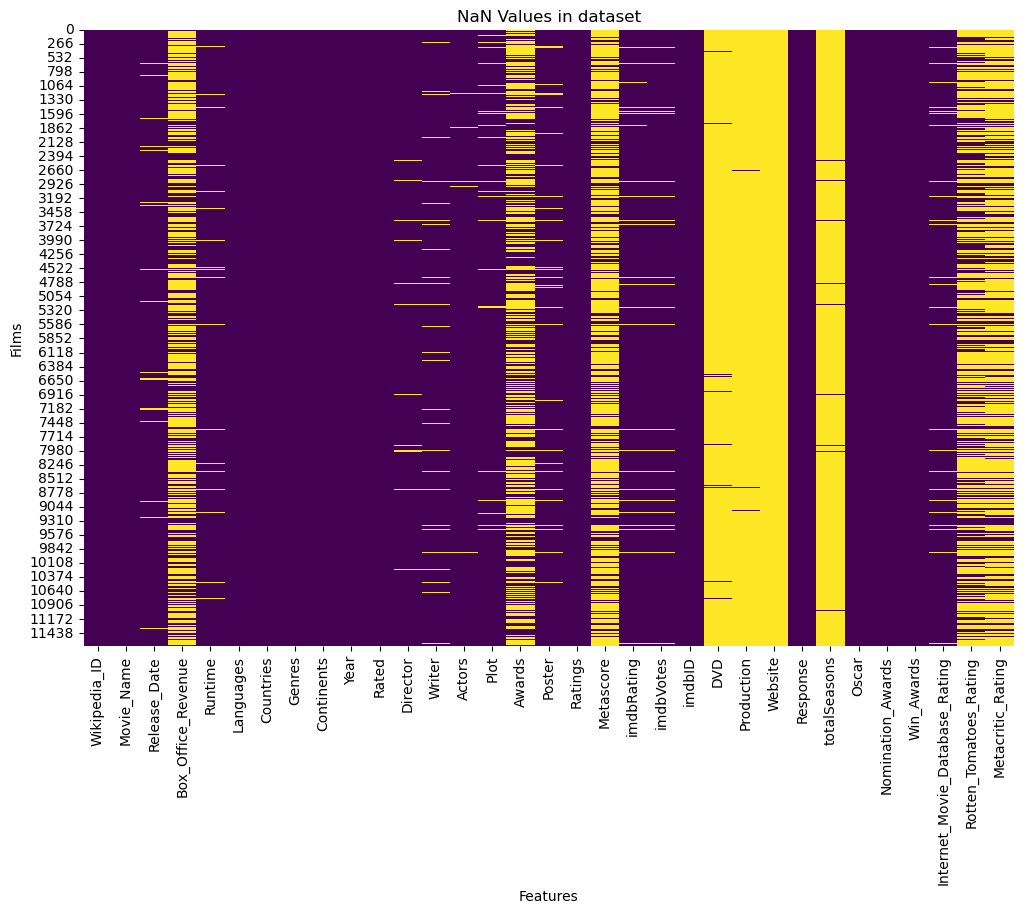

In [33]:
# Plot the NaN values in the feature matrix:
nan_mask_dropped = pd.isna(dataset_new)
plt.figure(figsize=(12, 8))
sns.heatmap(nan_mask_dropped, cbar=False, cmap='viridis')
plt.title('NaN Values in dataset')
plt.xlabel('Features')
plt.ylabel('Films')
plt.show()

# <h1 style="text-align:center; color: #FF6347;">AXE 1 : Commercial and Critical Success: A Comparative Study of Comedy Films in Europe and America 🎬🌍🇪🇺🇺🇸</h1>


This project examines the relationship between commercial success (box office) and critical acclaim (awards, ratings) specifically for comedy films in Europe versus those in America. By using OMDB data on revenues, ratings, and awards, we aim to analyze how these factors interact and differ by geographic context. The goal is to uncover the dynamics of success in the comedy genre within the global film industry, identifying what contributes to making a comedy film both profitable and critically acclaimed.

# Popularity vs. Quality: A Comparative Study of Box Office and Ratings


This code analyzes box office revenue for various comedy subgenres across different continents (America, Europe, and combined). It begins by cleaning and preparing the data, then visualizes revenue distributions by continent through histograms and comparative plots. Descriptive statistics are calculated for each continent. The code tests several statistical distributions to fit the data and identifies the best one. It also examines the most profitable comedy subgenres by continent. Finally, it evaluates correlations between box office revenue and critic ratings (IMDb, Rotten Tomatoes, Metacritic) for each continent using Spearman correlation.

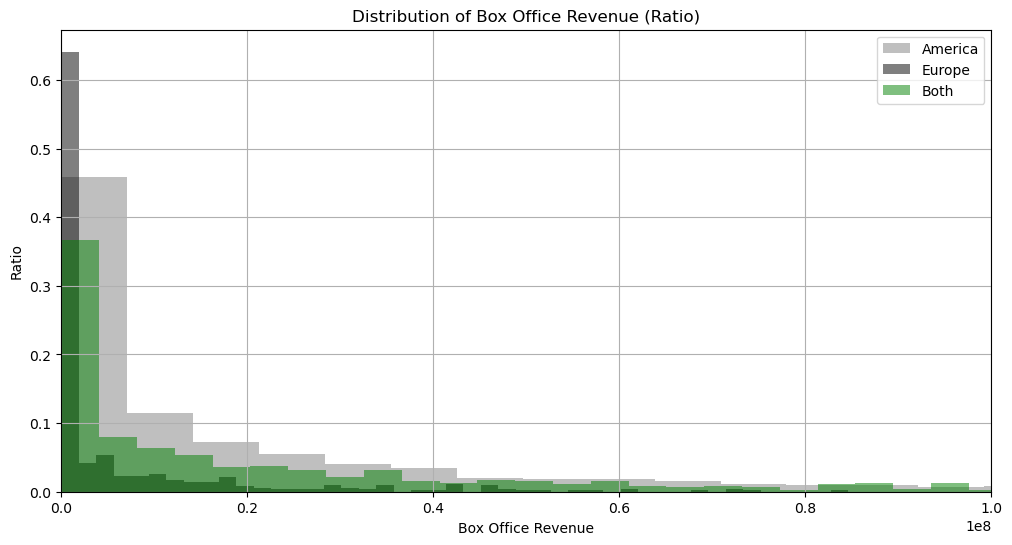

,Mean,Median,Standard Deviation,Q1,Q3
America,4.215332e+07,9600000.0,9.358275e+07,1228108.0,37591674.00
Europe,1.014050e+07,596858.0,2.982646e+07,87859.5,6740334.50
Both,4.135660e+07,11245111.0,7.896562e+07,969703.0,44369854.25


In [34]:

# Ensure the 'Box_Office_Revenue' column contains valid float values
merged_movie_metadata['Box_Office_Revenue'] = pd.to_numeric(merged_movie_metadata['Box_Office_Revenue'], errors='coerce')

# Drop rows with NaN values in the 'Box_Office_Revenue' column
revenue_data = merged_movie_metadata.dropna(subset=['Box_Office_Revenue'])

# Define the continents to plot
continents = ['America', 'Europe', 'Both']

# Create a single plot
plt.figure(figsize=(12, 6))

# Plot the histogram for each continent
for continent, color in zip(continents, ['grey', 'black', 'green']):
    continent_data = revenue_data[revenue_data['Continents'].apply(lambda x: continent in x)]
    total_count = len(continent_data)

    plt.hist(continent_data['Box_Office_Revenue'], bins=150, range=(0, continent_data['Box_Office_Revenue'].max()), 
             color=color, alpha=0.5, label=continent, weights=[1/total_count]*total_count)

# Add a title and labels
plt.title('Distribution of Box Office Revenue (Ratio)')
plt.xlabel('Box Office Revenue')
plt.xlim(0, 1e8)
plt.ylabel('Ratio')

# Add a legend
plt.legend()

# Activate grid
plt.grid(True)

# Display the plot
plt.show()

# Calculate basic statistics for Box Office Revenue for each continent
continent_stats = {}
for continent in continents:
    continent_data = revenue_data[revenue_data['Continents'].apply(lambda x: continent in x)]
    mean_revenue = continent_data['Box_Office_Revenue'].mean()
    median_revenue = continent_data['Box_Office_Revenue'].median()
    std_revenue = continent_data['Box_Office_Revenue'].std()
    q1_revenue = continent_data['Box_Office_Revenue'].quantile(0.25)
    q3_revenue = continent_data['Box_Office_Revenue'].quantile(0.75)
    continent_stats[continent] = {
        'Mean': mean_revenue,
        'Median': median_revenue,
        'Standard Deviation': std_revenue,
        'Q1': q1_revenue,
        'Q3': q3_revenue
    }

# Convert the dictionary to a DataFrame for better visualization
continent_stats_df = pd.DataFrame(continent_stats).T

# Display the DataFrame
display(continent_stats_df)

American films generate significantly higher average box office revenues (~42.2M) compared to European films (~10.1M). In Europe, the much lower median (~596K vs. ~9.6M in the U.S.) indicates a high proportion of low-revenue films, reflecting an asymmetric distribution. The high standard deviation for American films reveals substantial variability, driven by a few high-budget blockbusters, whereas in Europe, the lower standard deviation  shows a revenue distribution more concentrated around modest values.

In [35]:

# Charger les données de revenus au box-office dans une liste
box_office_revenues = merged_movie_metadata['Box_Office_Revenue'].dropna().values

# Définir une liste de distributions à tester
distributions = ['lognorm', 'expon', 'gamma', 'norm', 'pareto']

# Enregistrer les résultats
results = []

# Ajuster chaque distribution et calculer la qualité de l'ajustement
for distribution in distributions:
    dist = getattr(stats, distribution)
    params = dist.fit(box_office_revenues)
    
    # Calculer le score de qualité avec le test de Kolmogorov-Smirnov
    ks_stat, ks_p_value = stats.kstest(box_office_revenues, distribution, args=params)
    
    # Calculer le log-likelihood
    log_likelihood = np.sum(dist.logpdf(box_office_revenues, *params))
    
    results.append({
        'distribution': distribution,
        'params': params,
        'ks_stat': ks_stat,
        'ks_p_value': ks_p_value,
        'log_likelihood': log_likelihood
    })

# Identifier la distribution ayant le meilleur score
best_fit = min(results, key=lambda x: x['ks_stat'])

# Afficher les scores de chaque distribution
for result in results:
    print(f"Distribution: {result['distribution']}")
    print(f"  Params: {result['params']}")
    print(f"  KS Statistic: {result['ks_stat']}")
    print(f"  KS p-value: {result['ks_p_value']}")
    print(f"  Log-Likelihood: {result['log_likelihood']}")
    print()

print(f"La distribution qui s'ajuste le mieux est {best_fit['distribution']} avec un KS Statistic de {best_fit['ks_stat']} et un Log-Likelihood de {best_fit['log_likelihood']}.")


Distribution: lognorm
  Params: (2.7787697844231296, 109.75647745778906, 4255391.84357391)
  KS Statistic: 0.08491247516145217
  KS p-value: 4.340930765948154e-27
  Log-Likelihood: -75191.62410967087

Distribution: expon
  Params: (211.0, 38224063.8860372)
  KS Statistic: 0.3292962959739223
  KS p-value: 0.0
  Log-Likelihood: -78395.27030713914

Distribution: gamma
  Params: (0.3481448890122862, 1103690626.500352, 7.121602910510014e-24)
  KS Statistic: 1.0
  KS p-value: 0.0
  Log-Likelihood: -inf

Distribution: norm
  Params: (38224274.8860372, 87455231.87730695)
  KS Statistic: 0.33103026800755275
  KS p-value: 0.0
  Log-Likelihood: -83689.58177278243

Distribution: pareto
  Params: (0.4653855577950255, -1115111.1076378457, 1115322.1076378454)
  KS Statistic: 0.12097993743218394
  KS p-value: 1.2602664194975612e-54
  Log-Likelihood: -75759.25520174304

La distribution qui s'ajuste le mieux est lognorm avec un KS Statistic de 0.08491247516145217 et un Log-Likelihood de -75191.624109670

It is entirely expected for the log-normal distribution to be the best fit for box office revenues, as it effectively represents distributions where the majority of values are low but with some high extreme values.

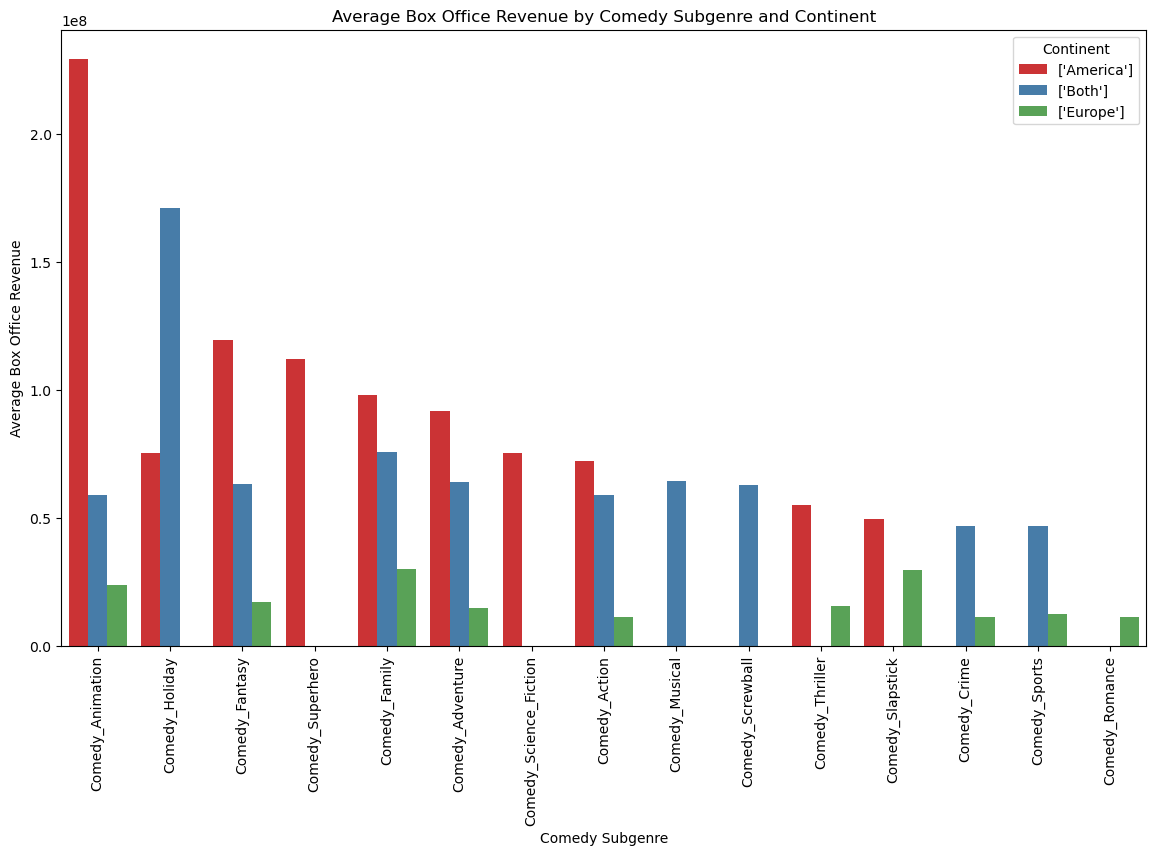

In [36]:

# Remove rows with 0 or NaN in the 'Box_Office_Revenue' column
merged_movie_metadata1 = merged_movie_metadata[merged_movie_metadata['Box_Office_Revenue'].notna() & (merged_movie_metadata['Box_Office_Revenue'] != 0)]

# Calculer les revenus moyens au box-office par sous-genre de comédie pour chaque continent
average_revenue_by_genre_continent = merged_movie_metadata1.explode('comedy_genres').groupby(['comedy_genres', 'Continents'])['Box_Office_Revenue'].mean().reset_index()

# Identifier les sous-genres de comédie les plus populaires dans chaque continent
top_genres_by_continent = average_revenue_by_genre_continent.sort_values(by='Box_Office_Revenue', ascending=False).groupby('Continents').head(10)

# Créer un barplot comparatif
plt.figure(figsize=(14, 8))
sns.barplot(data=top_genres_by_continent, x='comedy_genres', y='Box_Office_Revenue', hue='Continents', palette='Set1')

# Ajouter un titre et étiqueter les axes
plt.title('Average Box Office Revenue by Comedy Subgenre and Continent')
plt.xlabel('Comedy Subgenre')
plt.ylabel('Average Box Office Revenue')
plt.xticks(rotation=90)
plt.legend(title='Continent')

# Afficher le graphique
plt.show()

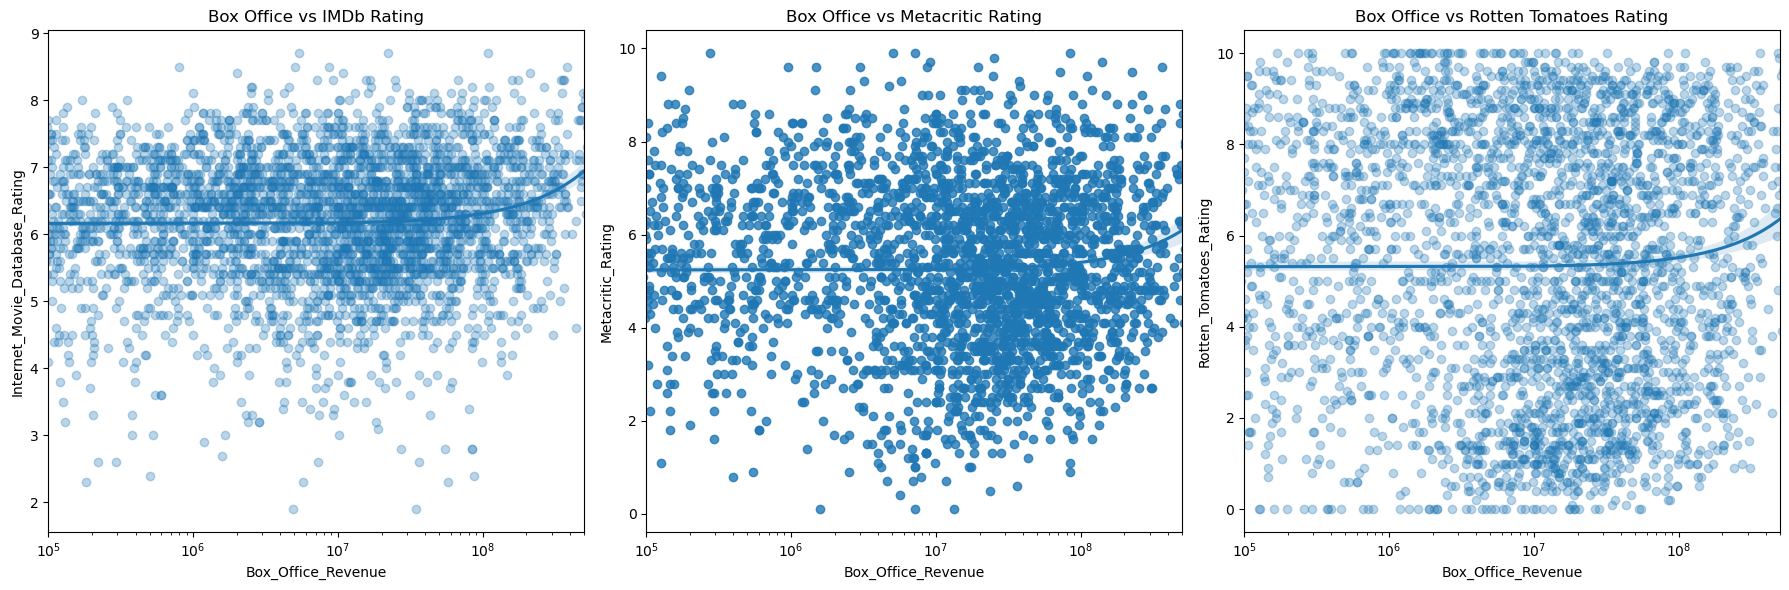

In [37]:

# Filter the data to include only rows with non-null values for Box_Office_Revenue and at least one of the ratings
filtered_data = merged_movie_metadata.dropna(subset=['Box_Office_Revenue', 'Internet_Movie_Database_Rating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating'], how='all')


# Créer une figure avec 3 sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Créer un jointplot pour 'Box_Office_Revenue' et 'Internet_Movie_Database_Rating' avec échelle logarithmique et transparence
sns.regplot(
    data=filtered_data, x='Box_Office_Revenue', y='Internet_Movie_Database_Rating', ax=axes[0],
    scatter_kws={'alpha':0.3}
)
axes[0].set_xscale("log")
axes[0].set_xlim(1e5, 0.5e9)
axes[0].set_title('Box Office vs IMDb Rating')

# Créer un hexbin plot pour 'Box_Office_Revenue' et 'Metacritic_Rating'
sns.regplot(
    data=filtered_data, x='Box_Office_Revenue', y='Metacritic_Rating', ax=axes[1]
)
axes[1].set_xscale("log")
axes[1].set_xlim(1e5, 0.5e9)
axes[1].set_title('Box Office vs Metacritic Rating')

# Créer un jointplot pour 'Box_Office_Revenue' et 'Rotten_Tomatoes_Rating' avec échelle logarithmique
sns.regplot(
    data=filtered_data, x='Box_Office_Revenue', y='Rotten_Tomatoes_Rating', ax=axes[2],
    scatter_kws={'alpha':0.3}
)
axes[2].set_xscale("log")
axes[2].set_xlim(1e5, 0.5e9)
axes[2].set_title('Box Office vs Rotten Tomatoes Rating')

# Afficher la figure
plt.tight_layout()
plt.show()


For a relationship between box office and score, Spearman correlation is more appropriate because it is less affected by outliers and better suited to non-linear relationships and asymmetric distributions.

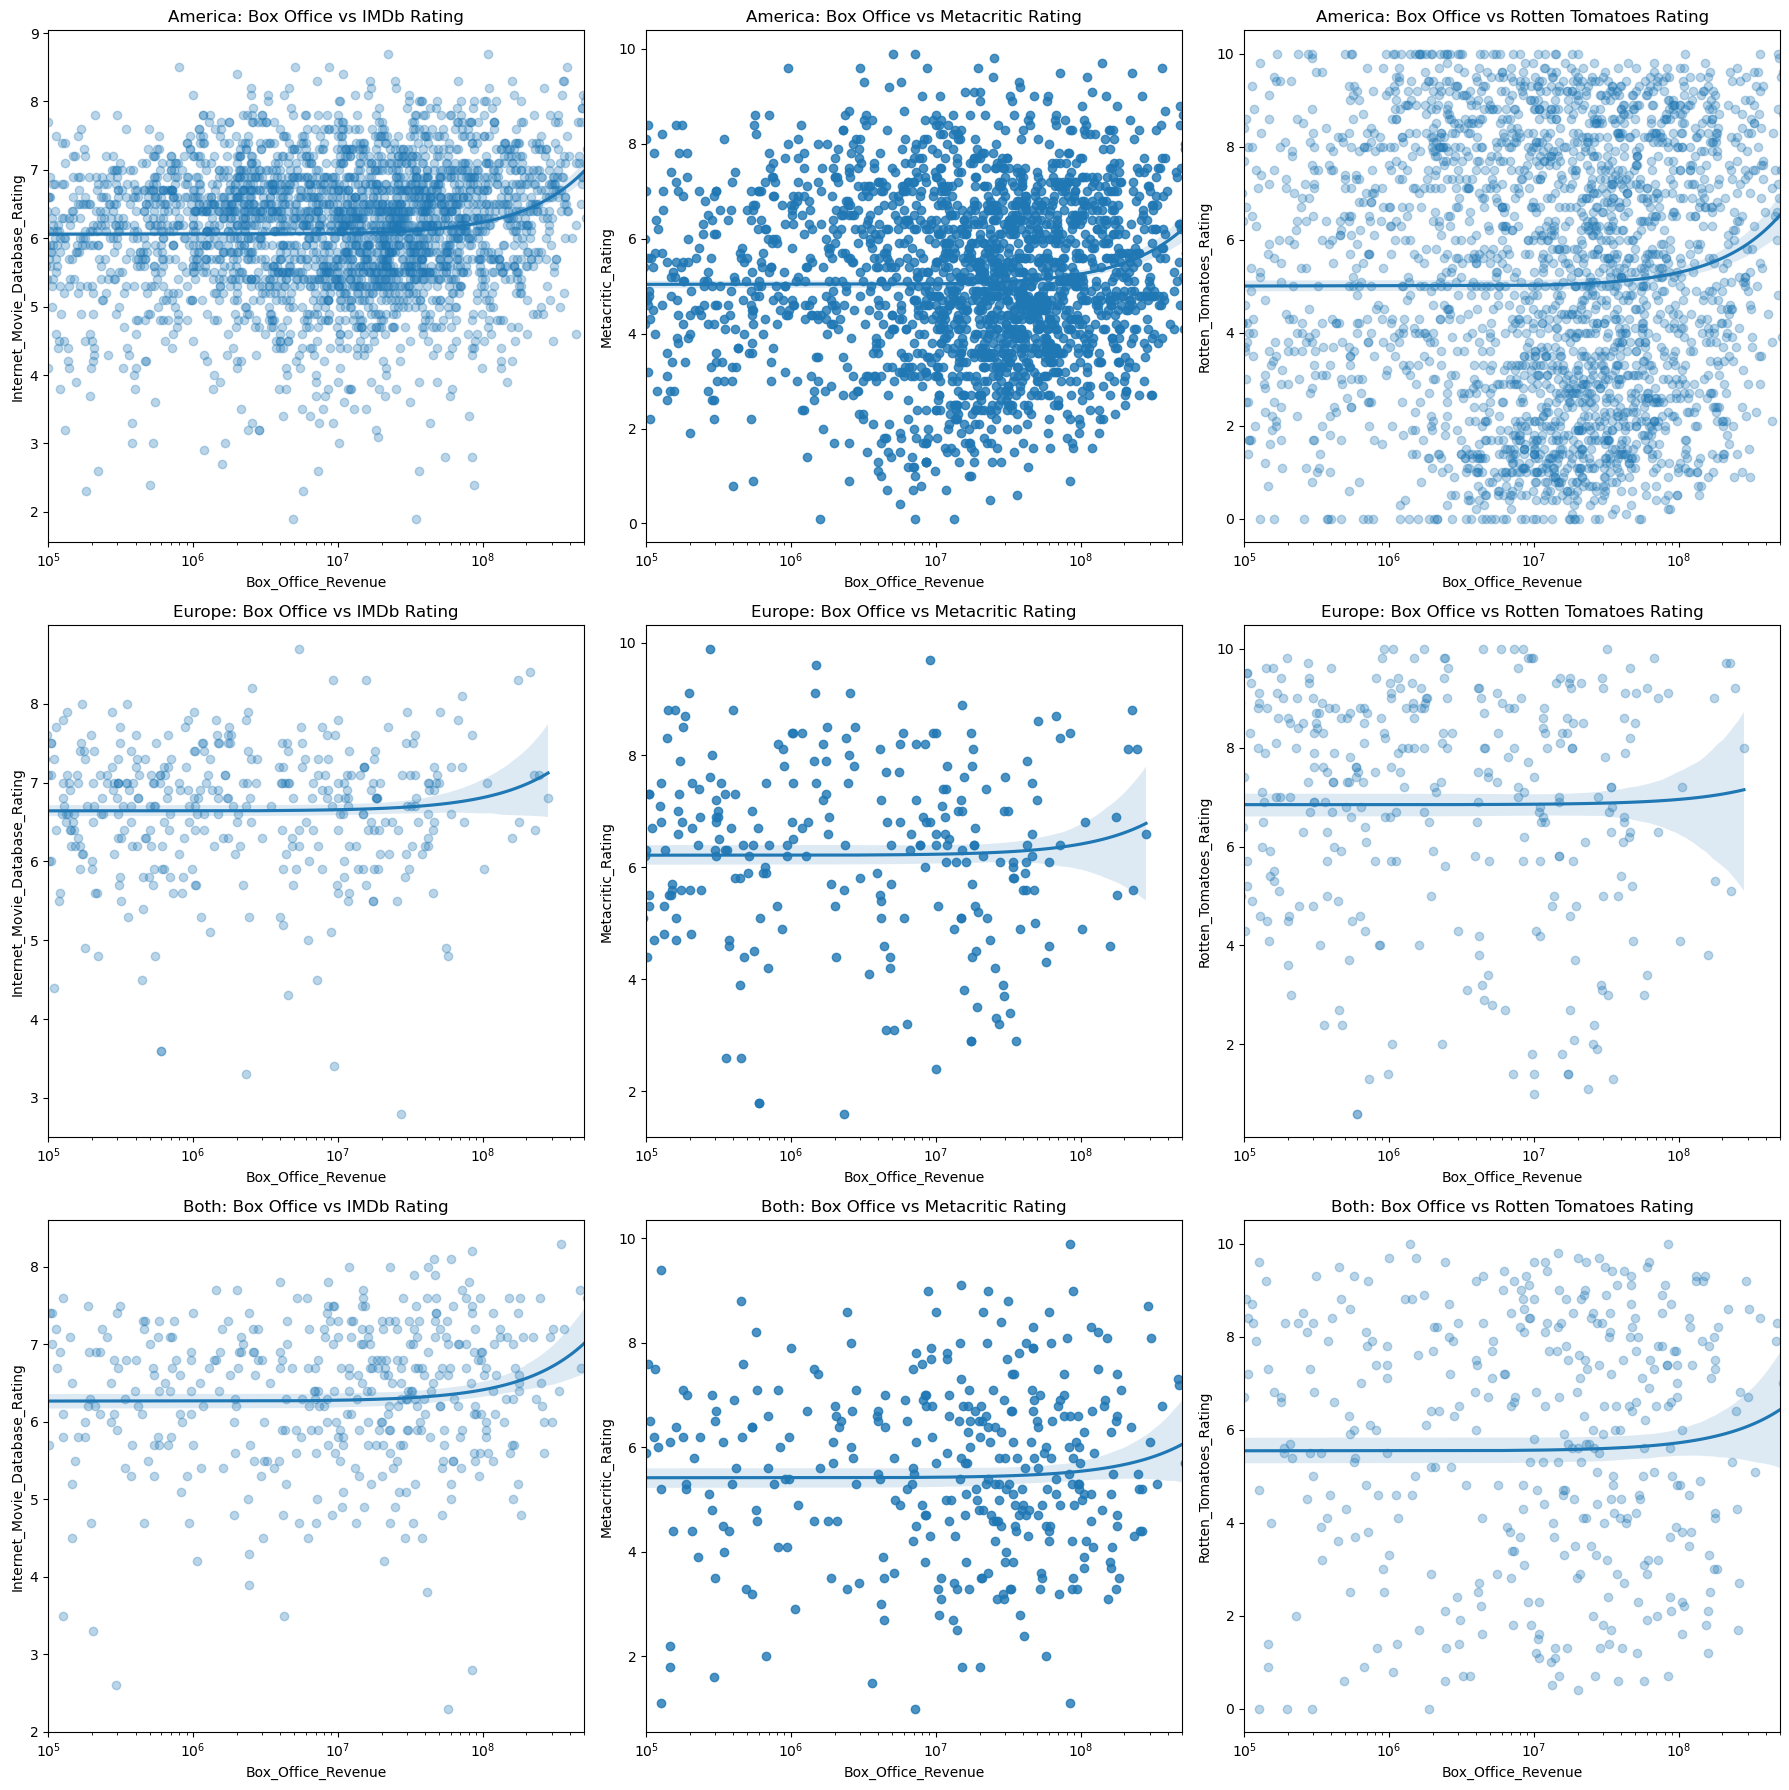

In [38]:

# Filter the data to include only rows with non-null values for Box_Office_Revenue and at least one of the ratings
filtered_data = merged_movie_metadata.dropna(subset=['Box_Office_Revenue', 'Internet_Movie_Database_Rating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating'], how='all')

# Définir les continents à analyser
continents = ['America', 'Europe', 'Both']

# Créer une figure avec 3 sous-graphiques pour chaque continent
fig, axes = plt.subplots(len(continents), 3, figsize=(18, 6 * len(continents)))

# Parcourir chaque continent et créer les graphiques de régression
for i, continent in enumerate(continents):
    continent_data = filtered_data[filtered_data['Continents'].apply(lambda x: continent in x)]
    
    # Créer un jointplot pour 'Box_Office_Revenue' et 'Internet_Movie_Database_Rating' avec échelle logarithmique et transparence
    sns.regplot(
        data=continent_data, x='Box_Office_Revenue', y='Internet_Movie_Database_Rating', ax=axes[i, 0],
        scatter_kws={'alpha':0.3}
    )
    axes[i, 0].set_xscale("log")
    axes[i, 0].set_xlim(1e5, 0.5e9)
    axes[i, 0].set_title(f'{continent}: Box Office vs IMDb Rating')

    # Créer un hexbin plot pour 'Box_Office_Revenue' et 'Metacritic_Rating'
    sns.regplot(
        data=continent_data, x='Box_Office_Revenue', y='Metacritic_Rating', ax=axes[i, 1]
    )
    axes[i, 1].set_xscale("log")
    axes[i, 1].set_xlim(1e5, 0.5e9)
    axes[i, 1].set_title(f'{continent}: Box Office vs Metacritic Rating')

    # Créer un jointplot pour 'Box_Office_Revenue' et 'Rotten_Tomatoes_Rating' avec échelle logarithmique
    sns.regplot(
        data=continent_data, x='Box_Office_Revenue', y='Rotten_Tomatoes_Rating', ax=axes[i, 2],
        scatter_kws={'alpha':0.3}
    )
    axes[i, 2].set_xscale("log")
    axes[i, 2].set_xlim(1e5, 0.5e9)
    axes[i, 2].set_title(f'{continent}: Box Office vs Rotten Tomatoes Rating')

# Afficher la figure
plt.tight_layout()
plt.show()


In [39]:
from scipy.stats import spearmanr

# Filter the data to include only rows with non-null values for Box_Office_Revenue and at least one of the ratings
filtered_data = merged_movie_metadata.dropna(subset=['Box_Office_Revenue', 'Internet_Movie_Database_Rating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating'], how='all')

# Define the continents to analyze
continents = ['America', 'Europe', 'Both']

# Initialize a dictionary to store the results
correlations = {
    'Continent': [],
    'Score Type': [],
    'Spearman Correlation': [],
    'p-value': [],
    'Significance': []
}

# Calculate Spearman correlation and p-value for each rating and continent
for continent in continents:
    continent_data = filtered_data[filtered_data['Continents'].apply(lambda x: continent in x)]
    for score_type, rating_column in zip(['Internet Movie Database', 'Rotten Tomatoes', 'Metacritic'], ['Internet_Movie_Database_Rating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating']):
        correlation, p_value = spearmanr(continent_data['Box_Office_Revenue'], continent_data[rating_column], nan_policy='omit')
        correlations['Continent'].append(continent)
        correlations['Score Type'].append(score_type)
        correlations['Spearman Correlation'].append(correlation)
        correlations['p-value'].append(p_value)
        if p_value < 0.05:
            significance = "YES"
        else:
            significance = "NO"
        correlations['Significance'].append(significance)

# Create a DataFrame to store the results
correlation_df = pd.DataFrame(correlations)

# Display the correlation table
display(correlation_df)


,Continent,Score Type,Spearman Correlation,p-value,Significance
0,America,Internet Movie Database,0.136595,3.865323e-15,YES
1,America,Rotten Tomatoes,0.024566,1.936836e-01,NO
2,America,Metacritic,0.066588,1.610712e-03,YES
3,Europe,Internet Movie Database,0.013382,7.635063e-01,NO
4,Europe,Rotten Tomatoes,-0.001806,9.699068e-01,NO
5,Europe,Metacritic,0.048977,3.751512e-01,NO
6,Both,Internet Movie Database,0.122589,9.160448e-03,YES
7,Both,Rotten Tomatoes,0.058265,2.328888e-01,NO
8,Both,Metacritic,0.071128,1.715840e-01,NO


# Rating of Comedies : Critics vs Users

### Source of Ratings: Critics vs. Public

This table shows whether each rating source displays ratings from critics or the public.

| Rating Source                  | Type of Rating     | Description                                                                                       |
|--------------------------------|--------------------|---------------------------------------------------------------------------------------------------|
| **imdbRating**                 | Public             | Rating provided by IMDb users.                                                                    |
| **Rotten_Tomatoes_Rating**     | Critics            | Represents the **Tomatometer** score, an aggregated rating from professional critics.             |
| **Metacritic_Rating**          | Critics            | Aggregated rating from professional critics, provided by Metacritic.                              |

### Summary
- **Critics’ Ratings**: Rotten_Tomatoes_Rating (Tomatometer) and Metacritic_Rating.
- **Public Ratings**: imdbRating.




In [40]:
# Explode the 'Types' column to have one type per row
exploded_dataset = dataset_Genre_Cleaned.explode('Types')


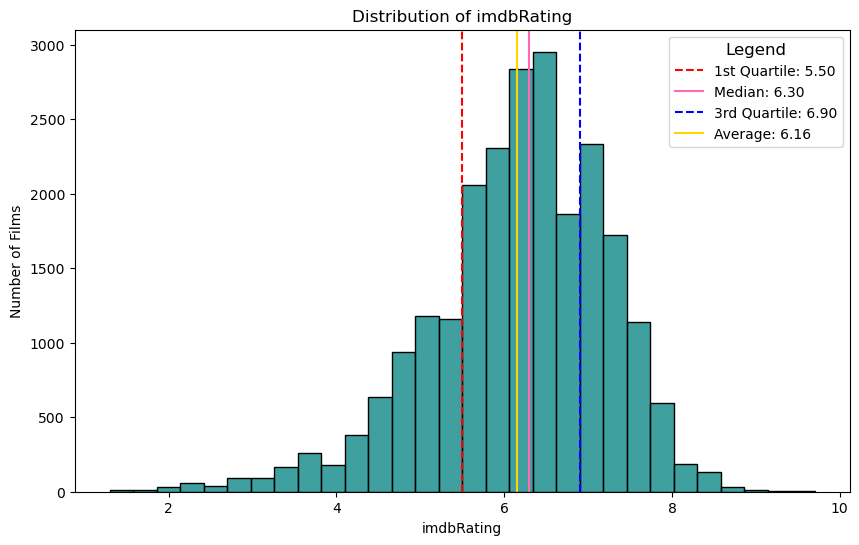

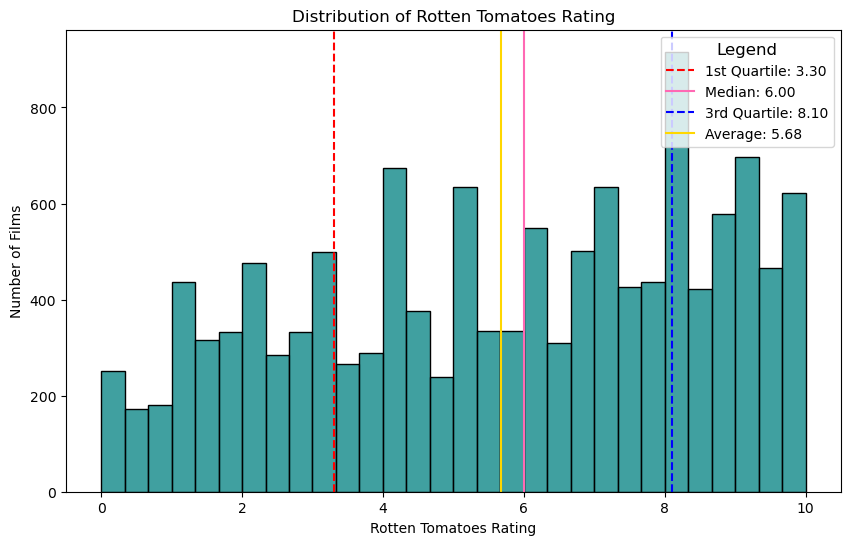

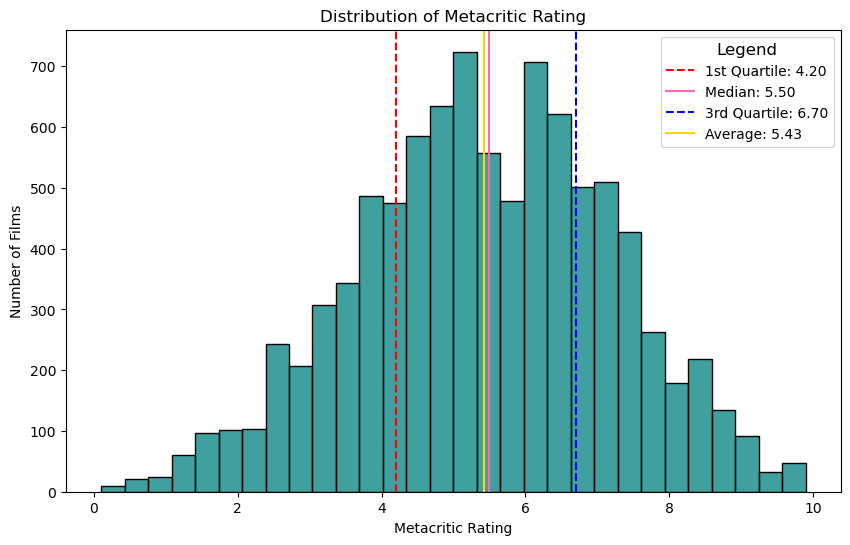

In [41]:
ratings_columns = ['imdbRating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating']

for rating in ratings_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(exploded_dataset[rating].dropna(), bins=30, kde=False, color='teal')
    plt.title(f'Distribution of {rating.replace("_", " ")}')
    plt.xlabel(rating.replace("_", " "))
    plt.ylabel('Number of Films')

    # Calculate and display the quartiles, median, and average of the ratings
    quartiles = exploded_dataset[rating].dropna().quantile([0.25, 0.5, 0.75])
    median = exploded_dataset[rating].dropna().median()
    average = exploded_dataset[rating].dropna().mean()

    plt.axvline(quartiles[0.25], color='r', linestyle='--', label='1st Quartile')
    plt.axvline(median, color='hotpink', linestyle='-', label='Median')
    plt.axvline(quartiles[0.75], color='b', linestyle='--', label='3rd Quartile')
    plt.axvline(average, color='gold', linestyle='-', label='Average')

    # Create a custom legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [f'1st Quartile: {quartiles[0.25]:.2f}', f'Median: {median:.2f}', f'3rd Quartile: {quartiles[0.75]:.2f}', f'Average: {average:.2f}']
    plt.legend(handles, labels, title='Legend', title_fontsize='large', loc='upper right')

    plt.show()


### Are the distributions normal ?

In [ ]:
for rating in ratings_columns :
    #print(dataset_Genre_Cleaned[rating].dropna().describe())
    # Perform the Kolmogorov-Smirnov test for normality on the 'IncomePerCap' column
    ks_statistic, p_value = diagnostic.kstest_normal(dataset_Genre_Cleaned[rating].dropna().values, dist='norm')
    print(f'Kolmogorov-Smirnov test for normality on {rating}: KS Statistic = {ks_statistic:.4f}, P-Value = {p_value:.4f}')

#### Kolmogorov-Smirnov Test for Normality on Movie Ratings

##### How the KS Test Works

1. **Define Hypotheses**:
   - **Null Hypothesis (H0)**: The data follows the specified distribution (e.g., normal distribution).
   - **Alternative Hypothesis (H1)**: The data does not follow the specified distribution.

2. **Calculate the KS Statistic**:
   - The KS statistic measures the maximum difference between the cumulative distribution of the sample data and the cumulative distribution of the normal distribution.
   - A larger KS statistic indicates a greater deviation between the sample data and the specified distribution.

3. **P-Value**:
   - The p-value tells us if the observed difference (measured by the KS statistic) is statistically significant.
   - A low p-value (typically < 0.05) means we can reject the null hypothesis and conclude that the data does not follow a normal distribution.
   - A high p-value (typically ≥ 0.05) means we fail to reject the null hypothesis, suggesting the data may follow a normal distribution.


### Results for Each Rating Source

| Rating Source                  | KS Statistic | P-Value | Interpretation                                                                                      |
|--------------------------------|--------------|---------|-----------------------------------------------------------------------------------------------------|
| **imdbRating**                 | 0.0648       | 0.0010  | The p-value of 0.001 suggests a significant deviation from normality, indicating this rating is not normally distributed. |
| **Rotten_Tomatoes_Rating**     | 0.0834       | 0.0010  | The highest KS statistic among all ratings, with a p-value of 0.001, suggesting a pronounced deviation from normality. |
| **Metacritic_Rating**          | 0.0350       | 0.0010  | Significant deviation from normality as indicated by the low p-value.                               |

### Summary

All ratings show p-values of 0.001, indicating that none of these datasets follow a normal distribution at a 0.05 significance level. The KS statistics for each rating source reinforce this conclusion, with **Rotten_Tomatoes_Rating** showing the highest deviation from normality. These results imply that assumptions of normality may not hold for analyses on these rating distributions.



## Analysis of Ratings: Do Critics Rate European Films More Severely Than Users? And the Same for American Films?



This analysis compares IMDb ratings (from users) with Rotten Tomatoes and Metacritic ratings (from critics) to determine if critics rate European and American films more severely than users.

### Methodology
- **Separate by Continent of Production**: The analysis is conducted separately for European and American films.
- **Combined Critic Ratings**: For each continent, Rotten Tomatoes and Metacritic ratings are combined into a single "Critics" group for analysis.
- **Statistical Tests**:
  - **Independent T-Test**: Used if both IMDb (user) and combined critics' ratings are normally distributed for each continent.
  - **Mann-Whitney U Test**: Used if the data is not normally distributed for each continent.
  
### Hypotheses

- **Null Hypothesis (H0)**: There is no difference between the ratings given by critics and users for films from each continent.
- **Alternative Hypothesis (H1)**: Critics rate films more severely than users for each continent, meaning critic ratings are lower than user ratings.

### Statistical Tests in Detail

#### Independent T-Test

The **Independent T-Test** compares the means of two independent groups (in this case, user ratings vs. critic ratings) to determine if there is a statistically significant difference between them.

- **Formula**:
  $
  t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
  $
  Where:
  - $\bar{X}_1$ and $\bar{X}_2$ are the sample means for the two groups (users and critics).
  - $s_1^2$ and $s_2^2$ are the variances of the two groups.
  - $n_1$ and $n_2$ are the sample sizes of the two groups.

- **Assumptions**:
  - The data for each group should be normally distributed.
  - Variances of the two groups should be equal (if not, an adjusted version of the T-Test, known as Welch's T-Test, is used).

- **Interpretation of Results**:
  - If the p-value < 0.05, we reject the null hypothesis, suggesting a significant difference in mean ratings between critics and users.
  - If the p-value ≥ 0.05, we fail to reject the null hypothesis, indicating no significant difference in mean ratings.

#### Mann-Whitney U Test

If the data is not normally distributed, the **Mann-Whitney U Test** is a non-parametric alternative that compares the distributions of the two independent groups.

- **Formula**:
  $
  U = n_1 n_2 + \frac{n_1 (n_1 + 1)}{2} - R_1
  $
  Where:
  - $U$ is the test statistic.
  - $n_1$ and $n_2$ are the sample sizes of the two groups.
  - $R_1$ is the sum of ranks for the first group (users).

- **Interpretation of Results**:
  - If the p-value < 0.05, we reject the null hypothesis, indicating a significant difference in the distributions of ratings between critics and users.
  - If the p-value ≥ 0.05, we fail to reject the null hypothesis, suggesting no significant difference in distributions.

### Interpretation of Results
- **If p-value < 0.05**: Reject the null hypothesis, suggesting that critics rate films from that continent more severely than users.
- **If p-value ≥ 0.05**: Fail to reject the null hypothesis, indicating no significant difference between user and critic ratings for films from that continent.

### Summary

- **Independent T-Test** is used if ratings for each group (user and critic) are normally distributed.
- **Mann-Whitney U Test** is used as an alternative if data is not normally distributed.




In [ ]:
# Filter the dataset for the continents 'Europe' and 'America'
filtered_dataset = exploded_dataset.loc[exploded_dataset['Continents'].isin(['Europe', 'America'])]

# Separate user and critic ratings for each continent
europe_user_ratings = filtered_dataset[(filtered_dataset['Continents'] == 'Europe')]['imdbRating'].dropna()
europe_critic_ratings = filtered_dataset[(filtered_dataset['Continents'] == 'Europe')][['Rotten_Tomatoes_Rating', 'Metacritic_Rating']].dropna().values.flatten()
america_user_ratings = filtered_dataset[(filtered_dataset['Continents'] == 'America')]['imdbRating'].dropna()
america_critic_ratings = filtered_dataset[(filtered_dataset['Continents'] == 'America')][['Rotten_Tomatoes_Rating', 'Metacritic_Rating']].dropna().values.flatten()

# Define a function to perform the test based on normality
def compare_ratings(user_ratings, critic_ratings, continent):
    # Check normality to decide on the test
    if stats.shapiro(user_ratings).pvalue > 0.05 and stats.shapiro(critic_ratings).pvalue > 0.05:
        # If both distributions are normal, use an independent T-Test
        t_stat, p_value = stats.ttest_ind(user_ratings, critic_ratings, alternative='greater', equal_var=False)
        test_name = "T-Test"
    else:
        # Use Mann-Whitney U Test if data is not normally distributed
        u_stat, p_value = stats.mannwhitneyu(user_ratings, critic_ratings, alternative='greater')
        test_name = "Mann-Whitney U Test"
    
    # Output the results
    print(f"\n{test_name} Results for {continent} Films:")
    print(f"P-Value: {p_value}")
    if p_value < 0.05:
        print("Result: Critics rate films more severely than users (significant difference).")
    else:
        print("Result: No significant difference between critics' and users' ratings.")

# Run the test for Europe
compare_ratings(europe_user_ratings, europe_critic_ratings, "European")

# Run the test for America
compare_ratings(america_user_ratings, america_critic_ratings, "American")

### Summary of Mann-Whitney U Test Results: Do Critics Rate Films More Severely Than Users?

This table summarizes the results of the Mann-Whitney U Test comparing user and critic ratings for European and American films.

| Continent        | Test Statistic  | P-Value                   | Interpretation                                                                                           |
|------------------|-----------------|---------------------------|----------------------------------------------------------------------------------------------------------|
| **European Films** | Mann-Whitney U | 0.9999999999998804        | No significant difference between critics' and users' ratings; critics and users rate European films similarly. |
| **American Films** | Mann-Whitney U | 6.65e-192                 | Significant difference; critics rate American films more severely than users.                             |

### Additional Notes
- **Warning**: The large sample size (N > 5000) may impact the accuracy of the p-values, as indicated by a warning from the test. However, the results remain interpretable, especially for indicating significant differences.


# Are European Comedies Juged Better Than American Comedies

In [ ]:
for rating in ratings_columns:    
    europe_ratings = dataset_Genre_Cleaned.loc[dataset_Genre_Cleaned['Continents'] == 'Europe'][rating].dropna()
    america_ratings = dataset_Genre_Cleaned.loc[dataset_Genre_Cleaned['Continents'] == 'America'][rating].dropna()
    print("The rating of",rating, " " ,stats.ttest_ind(europe_ratings, america_ratings))

## T-Test Analysis of Ratings by Continent of Production



This analysis compares the average ratings of comedies produced in Europe and America using an independent t-test to determine if there are statistically significant differences in ratings based on the continent of production.

### Results

| Rating Source                  | T-Test Statistic | P-Value               | Degrees of Freedom | Interpretation                                                                                      |
|--------------------------------|------------------|-----------------------|--------------------|-----------------------------------------------------------------------------------------------------|
| **imdbRating**                 | 9.283            | 1.97e-20              | 10,443             | Significant difference in IMDb ratings between European and American-produced comedies, suggesting differing rating patterns. |
| **Rotten_Tomatoes_Rating**     | 13.356           | 6.86e-40              | 4,260              | Strongest observed difference, with a very high t-statistic, showing marked rating variation based on the continent of production. |
| **Metacritic_Rating**          | 10.086           | 1.57e-23              | 2,842              | Significant difference in ratings between European and American-produced comedies, similar to Rotten Tomatoes.           |

### Summary

All rating sources demonstrate statistically significant differences between comedies produced in Europe and America. This suggests that the continent of production may strongly influence movie ratings on these platforms. With very low p-values (all well below 0.05), we can be confident that these differences are not due to random chance and reflect actual rating patterns that vary by continent of production.


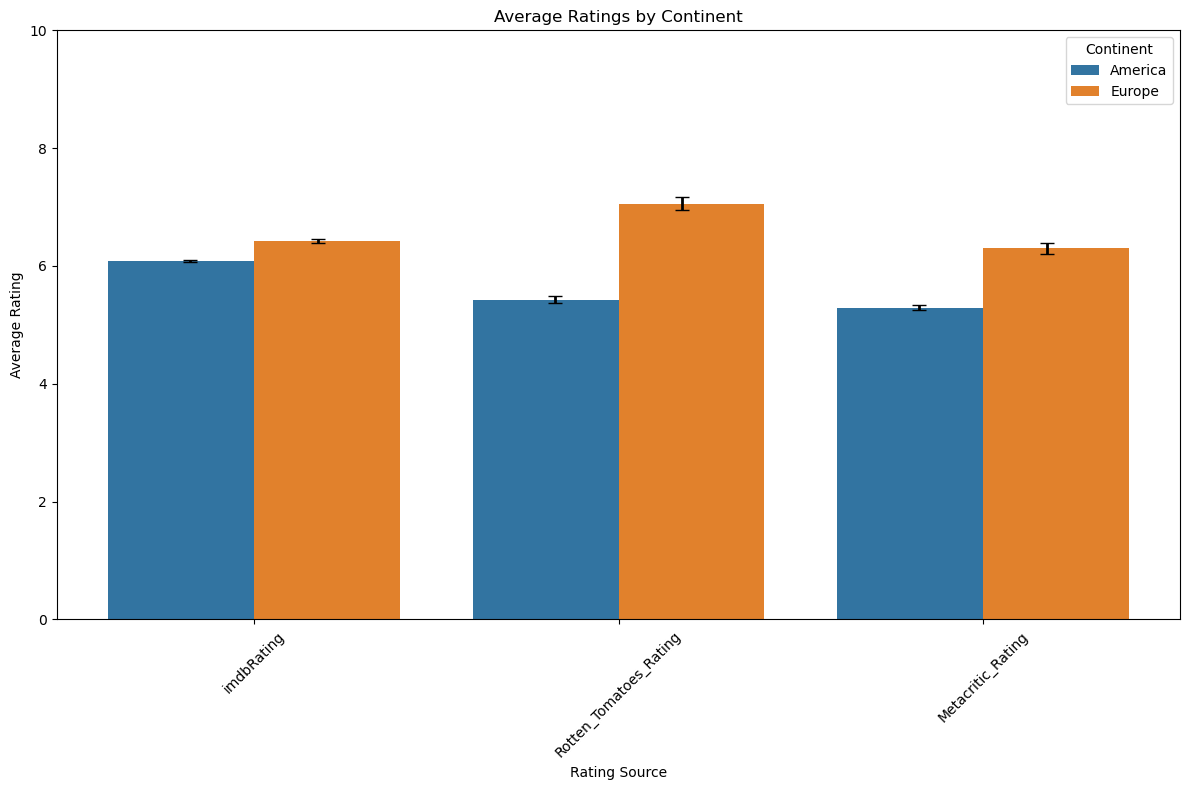

In [45]:
# Filter the dataset for the continents 'Europe' and 'America'
filtered_dataset = exploded_dataset.loc[exploded_dataset['Continents'].isin(['Europe', 'America'])]

# Calculate the average rating per continent, ignoring NaNs
average_ratings = filtered_dataset.groupby('Continents')[ratings_columns].mean().reset_index()

# Melt the dataframe for easier plotting with seaborn
melted_ratings = average_ratings.melt(id_vars='Continents', var_name='Rating_Source', value_name='Average_Rating')

# Divide the Metascore and its confidence intervals by 10 for better comparison
melted_ratings.loc[melted_ratings['Rating_Source'] == 'Metascore', 'Average_Rating'] /= 10

# Calculate the confidence intervals, excluding NaNs
conf_intervals = filtered_dataset.groupby('Continents')[ratings_columns].agg(
    lambda x: stats.t.interval(0.95, len(x.dropna())-1, loc=np.mean(x.dropna()), scale=stats.sem(x.dropna()))
)

# Prepare the plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Rating_Source', y='Average_Rating', hue='Continents', data=melted_ratings, errorbar=None)
plt.ylim([0, 10])
plt.title('Average Ratings by Continent')
plt.xlabel('Rating Source')
plt.ylabel('Average Rating')

# Width of each bar group, adjust if necessary based on Seaborn's bar width
bar_width = 0.35

# Add error bars in black, centered within each bar
for j, rating_source in enumerate(ratings_columns):
    for i, continent in enumerate(average_ratings['Continents']):
        lower_bound, upper_bound = conf_intervals.loc[continent, rating_source]
        y_value = average_ratings.loc[average_ratings['Continents'] == continent, rating_source].values[0]
        
        # If rating source is Metascore, adjust y_value accordingly
        if rating_source == "Metascore":
            y_value /= 10
        
        # Calculate the x position centered for each bar in the group
        x_pos = j - bar_width/2 + i * bar_width
        
        # Plot the error bar in black
        ax.errorbar(x=x_pos, y=y_value, 
                    yerr=[[y_value - lower_bound], [upper_bound - y_value]], 
                    fmt='none', c='black', capsize=5, lw=2)

plt.legend(title='Continent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Loop through each rating in the ratings columns and print detailed confidence interval information
for rating in ratings_columns:
    europe_ci = conf_intervals.loc['Europe', rating]
    america_ci = conf_intervals.loc['America', rating]
    
    print(f"\n### {rating} ###")
    print(f"Europe Confidence Interval: {europe_ci}")
    print(f"America Confidence Interval: {america_ci}")
    
    # Check if intervals overlap
    if europe_ci[0] > america_ci[1] or america_ci[0] > europe_ci[1]:
        print("Interpretation: The confidence intervals do not overlap, indicating a statistically significant difference.")
    else:
        print("Interpretation: The confidence intervals overlap, suggesting no statistically significant difference.")


## Confidence Interval Analysis of Movie Ratings by Continent of Production



This table summarizes the confidence intervals (CIs) for movie ratings of comedies produced in Europe and America across various rating sources. The non-overlapping confidence intervals indicate statistically significant differences in average ratings between the continents of production.

| Rating Source               | Europe CI                  | America CI                | Interpretation                                                                                                                                                             |
|-----------------------------|----------------------------|---------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **imdbRating**              | (6.39, 6.45)               | (6.07, 6.10)             | Non-overlapping intervals suggest a significant difference, with European-produced comedies rated slightly higher than American-produced comedies on IMDb.                                       |
| **Rotten_Tomatoes_Rating**  | (6.95, 7.16)               | (5.37, 5.48)             | Significant difference indicated by non-overlapping intervals, with European comedies receiving notably higher ratings on Rotten Tomatoes compared to American comedies.                     |
| **Metacritic_Rating**       | (6.20, 6.40)               | (5.25, 5.33)             | Non-overlapping intervals show a statistically significant difference, with European comedies rated higher than American comedies on Metacritic.                                         |

### Summary of Findings
- **Statistically Significant Differences**: All rating sources show non-overlapping confidence intervals between European and American comedies, indicating significant differences in average ratings based on the continent of production.
- **Higher Ratings for European Comedies**: European-produced comedies have consistently higher ratings across all platforms compared to American-produced comedies, reflecting potential cultural or perceptual differences in movie appreciation.
- **Implications**: These findings are essential for cross-continental comparisons of movie ratings, as production region appears to impact ratings and may reflect different preferences or rating standards across platforms.


# <h1 style="text-align:center; color: #32CD32;">AXE 2 : Narrative Themes and Movie Plots Analysis 📖🎥</h1>


In this axis, we aim at focusing on a more Natural Language Processing (NLP) strategy to process the CMU movie dataset.

In [49]:
# === Load Data and Plot Summaries ===
DATASET_FILEPATH = Path("data/Utils/merged_movie_metadata.csv")
PLOT_SUMMARIES_FILEPATH = Path("data/MovieSummaries.nosync/plot_summaries.txt")

df = pd.read_csv(DATASET_FILEPATH)

# Take only unique Wikipedia_ID
df = df.drop_duplicates(subset=['Wikipedia_ID'])

plot_summaries = {}

with open(PLOT_SUMMARIES_FILEPATH, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split('\t', 1)
        if len(parts) == 2:
            wiki_id, summary = parts
            plot_summaries[int(wiki_id)] = summary

# Map plot summaries to the DataFrame
df['Plot_Summary_Base'] = df['Wikipedia_ID'].map(plot_summaries)

### Loading and Preparing Movie Plot Summaries

Our dataset includes two main sources for movie plot summaries:

1. **OMDB Data (Plot column)**: This source provides a brief summary of the movie plot in a few sentences.
2. **CMU Movie Summary Corpus (plot_summaries.txt)**: This file, obtained from the [CMU Movie Summary Corpus website](https://www.cs.cmu.edu/~ark/personas/), contains detailed plot summaries for a range of movies.

Since both sources may contain missing values for certain movies, we will combine the two to maximize coverage and ensure we have plot information for as many movies as possible. Below is a check to see how many values are missing in each plot source:

In [50]:
# Check missing values in both plot sources
print(f"Total movies: {len(df)}")
print(f"Missing values in OMDB Plot column: {df['Plot'].isna().sum()}")
print(f"Missing values in CMU Plot Summary column: {df['Plot_Summary_Base'].isna().sum()}")

# Movies missing both plot summaries
print(f"Movies missing both summaries: {(df['Plot'].isna() & df['Plot_Summary_Base'].isna()).sum()}")

Total movies: 11681
Missing values in OMDB Plot column: 423
Missing values in CMU Plot Summary column: 4076
Movies missing both summaries: 362


## Additionnal dataset

For our journey, we will need to retrieve an aditionnal dataset from the internet. We will get it from OMDB [Open Movie Database](https://www.omdbapi.com), an open API that allows to retrieve movie metadata from their IMDBId, or even simpler, from their title.

After getting an API key, we managed to query the database for $73'000$ movies out of the $\approx 83'000$ original movies of `movie_metadata.tsv` from CoreNLP.

The resulting `.json` file was merged with the original CoreNLP dataset, adding the following columns :

    ["Rated", "Director", "Writer", "Actors", "Plot", "Awards", "Poster", "Ratings", "Metascore", "imdbRating", "imdbVotes", "imdbID", "DVD", "Production", "Website", "Response", "totalSeasons", "Oscar", "Nomination_Awards", "Win_Awards", "Internet_Movie_Database_Rating", "Rotten_Tomatoes_Rating", "Metacritic_Rating"]

We can then process to our text-based analysis.

### Text Preprocessing for Movie Plots

To analyze movie plots, we need to process the text data to standardize and clean it. We perform several key steps in this process:

1. **Text selection** - For each movie, we prioritize plot summaries from the [CMU Movie Summary Corpus](https://www.cs.cmu.edu/~ark/personas/) because they tend to be richer in content. If a summary from this source is unavailable (i.e., a missing value), we use the summary from OMDB. If both sources are missing, the result will be marked as `NaN`.
   
2. **Tokenization** We split each plot summary into individual words (tokens).

3. **Stop words removal** Commonly used words that don’t contribute meaningful information (known as stop words) are removed. Examples of stop words include "the," "is," "and," "in," "to," etc.

4. **Lemmatization** Each word is reduced to its base or root form. For instance, words like "running," "runs," and "ran" are all converted to "run". This helps improve the accuracy of our analysis by avoiding duplicates in different forms. This process is called.

5. **Frequency analysis** We analyze the frequency and type of words used.


In [51]:
# === Text Preprocessing ===
from src.utils.data_utils import tok_by_region

# Tokenize plots by region
tokenized_plots_america = tok_by_region(df, 'America')
tokenized_plots_europe = tok_by_region(df, 'Europe')
tokenized_plots_both = tok_by_region(df, 'Both')

We now want to see the most frequently used words in movie plots across our three regions: **America**, **Europe**, and **Both**. We use a `Counter` to count occurrences of each word in the tokenized plots for each region.

In [52]:
# === Word Counts ===
from src.utils.data_utils import get_word_count

word_count_america = get_word_count(tokenized_plots_america)
word_count_europe = get_word_count(tokenized_plots_europe)
word_count_both = get_word_count(tokenized_plots_both)

print("Top 10 words in America:", word_count_america.most_common(10))
print("\nTop 10 words in Europe:", word_count_europe.most_common(10))
print("\nTop 10 words in Both:", word_count_both.most_common(10))

Top 10 words in America: [('get', 6140), ('find', 5148), ('go', 5088), ('one', 4688), ('back', 4513), ('take', 4335), ('new', 3921), ('tell', 3897), ('friend', 3740), ('two', 3736)]

Top 10 words in Europe: [('one', 895), ('film', 878), ('get', 846), ('find', 821), ('go', 774), ('life', 772), ('take', 734), ('two', 722), ('friend', 682), ('love', 634)]

Top 10 words in Both: [('find', 642), ('get', 574), ('go', 561), ('one', 544), ('take', 494), ('two', 459), ('back', 448), ('tell', 441), ('new', 408), ('film', 407)]


We now have the most frequently used words in each region’s plot summaries, but these results feel somewhat limited. To gain deeper insights, we’ll use the Stanford CoreNLP-processed summaries, which provide richer linguistic information.

These summaries, derived from `plot_summaries.txt`, have been processed with the [Stanford CoreNLP pipeline](https://stanfordnlp.github.io/CoreNLP/), a tool that performs advanced language processing tasks such as part-of-speech tagging, syntactic parsing, named entity recognition (NER), and coreference resolution. This additional information will allow us to analyze not only word frequency but also the context and roles of words within each summary. We will first extract the **POS tags**.

First, let's configure the folder where we store these summaries (not included in github due to the large space it takes) :

In [53]:
folder_path = Path("../corenlp_plot_summaries")

assert folder_path.exists(), "Must configure the correct path to corenlp_plot_summaries"

AssertionError: Must configure the correct path to corenlp_plot_summaries

Then, let's see how many movies that have their summaries processed.

 > **Note :** originally, only ~7'000 movies were processed. We added 3'500 missing movies by processing their OMDB plot summaries instead. This was a bit of a headache and since this is preprocessing, the logic was moved inside `src/scripts/` to lighten the notebook. See [extract_ids_to_run_in_pipeline.py](src/scripts/extract_ids_to_run_in_pipeline.py) and [INTELLIJ_run_Stanford_Pipeline.xml](src/scripts/INTELLIJ_run_Stanford_Pipeline.xml) for details on how this was achieved.

In [ ]:
# count matching folders/files
processed_ids = {f.stem.replace(".xml", "") for f in folder_path.glob("*.xml.gz")}
available_ids = set(df["Wikipedia_ID"].astype(str))
matching_files = [folder_path/f"{filename}.xml.gz" for filename in processed_ids.intersection(available_ids)]

print(f"Number of matching folders/files: {len(matching_files)}")
print(f"Number of unique Wiki id's: {df['Wikipedia_ID'].nunique()}")

### Filter using the POS fields

**POS (Part Of Speech) fields contains word metadata. It indicates whether the current word is a noun, a verb, an adjective, etc.**

[An example POS definition can be found here](https://en.wikipedia.org/wiki/Brown_Corpus#Part-of-speech_tags_used) :

![POS example definition](data/POS_tokens_BrownCorpusWikipedia.png)

We need to know what kind of fields we have in our files to extract the most useful ones for our analysis. To do so, and to avoid unzipping all the xml files to the computer, we can leverage bash tools and use this (non-optimized) command. However, even if this method is (quiet) efficient, it would still take a long time to process all the files. Since we use this command only to get a grasp of the POS fields, we executed it on a subset of files chosen randomly. We just replace "*xml.gz" with the first 5000 files after being sorted randomly.


```bash
    zcat  $(ls *.xml.gz | sort -R | head -n5000) | grep -oP "(?<=<POS>)[^<]+" | sort | uniq -c | sort -rn
```

How it works :
 - `$(ls *.xml.gz | sort -R | head -n5000)` returns 5000 randomly chosen filenames inside the current directory.
 - `zcat` displays the content of a .gz (gzipped) file as text
 - The output is piped to `grep` which extracts all the POS fields as strings : "(...) <POS>NN</POS> (...)" => "NN" 
 - The output is piped to `sort` which sorts this sequence of strings
 - The output is piped to `uniq` which prints each string only once, preceded with its number of occurences
 - The output is piped to `sort` which sorts the list of string occurences by descending order.


Which gives as output :

```text
     250061 NN
     185484 IN
     164548 NNP
     162675 DT
     116598 VBZ
      93384 ,
     [...]
```

We redirect the output to a file `data/POS_tokens.csv` and read it with pandas :



In [ ]:
df_pos = pd.read_csv("data/POS_tokens.csv", sep=" ", header=None)
df_pos.columns = ["occurence", "token"]
plt.figure(figsize=(10, 6))
df_pos.plot(x='token', y='occurence', kind='bar', color='skyblue')
plt.title(f'Repartition of the POS field content in 5000 files.', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('POS', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xticks(rotation=90)
plt.show()

Now that we have a clear idea of the most commonly used POS tags, we can use this information to focus on the tags that will be most relevant and insightful for our analysis. 
Let's now see how many films in our dataset have gone through the Stanford CoreNLP pipeline:

### Running the CoreNLP pipeline on the OMDB plots summaries (fallback)

Out of a total of 11'681 films, 11'319 have been processed through the Stanford CoreNLP pipeline.

To work with the Stanford CoreNLP-processed data, we define the following functions:

1. **`get_sentence_word_metadata`**:
   - This function retrieves metadata from the CoreNLP pipeline output for a given movie ID. 
   - It extracts tokens, their lemmas, and part-of-speech (POS) tags from `.xml.gz` files.

2. **`filter_words_by_pos`**:
   - This function filters tokens based on specified POS tags, allowing us to focus on particular types of words, such as nouns, verbs, or adjectives.

3. **`filter_words_by_pos_ngram`**:
   - This function generates n-grams (sequences of n consecutive words) from the tokenized data, filtered by the specified POS tags. It is useful for capturing patterns and contexts in the text.

We also define three sets of ids for each region ("Europe", "America" or both of them).

In [ ]:
from src.utils.data_utils import filter_words_by_pos, filter_words_by_pos_ngram, get_sentence_word_metadata

# === Define Regions ===
region_ids = {
    "America": set(df[df['Continents'].str.contains("America")]['Wikipedia_ID'].astype(str)),
    "Europe": set(df[df['Continents'].str.contains("Europe")]['Wikipedia_ID'].astype(str)),
    "Both": set(df[df['Continents'].str.contains("Both")]['Wikipedia_ID'].astype(str))
}

After we've successfully extracted the words we wanted, the next step is to visualize them. To do this, we will use a word cloud visualization to display the most frequent words. In a word cloud, word size represent their frequency of occurence. This gives immediately a grasp of the word occurences.

In [ ]:
# === Word Cloud Generation ===
def generate_word_cloud(region, pos_tags, title, mask_image=None, sample_output=True, ngrams=1):
    """Generates a word cloud for a specified region and POS tags, with optional mask and sample output."""
    word_counter = Counter()
    for wiki_id in tqdm(region_ids[region]):
        tokens_metadata = get_sentence_word_metadata(folder_path, wiki_id)
        filtered_words = filter_words_by_pos(tokens_metadata, pos_tags) if ngrams == 1 else filter_words_by_pos_ngram(tokens_metadata, pos_tags, ngrams)
        word_counter.update(filtered_words)
    
    if sample_output:
        # print sample output for verification
        print(f"\nSample of filtered words for {region} - {title}:")
        print(word_counter.most_common(10))
    
    # word_counter.subtract(word_counter.most_common(6))
    
    # generate and display the word cloud with mask if provided
    wordcloud = WordCloud(width=800, height=400, background_color='white', mask=mask_image,
                          contour_color='black', contour_width=1).generate_from_frequencies(word_counter)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{title} Word Cloud for {region}")
    plt.show()

Using the POS tags defined above, we can group the tags into specific categories (e.g., nouns, verbs, adjectives) to filter tokens for our word cloud.

In [ ]:

# === POS Tags Groups ===
noun_tags = ['NN', 'NNA', 'NNC', 'NNS', 'NNP', 'NNPS']
verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBS', 'VBZ']
adjective_tags = ['JJ', 'JJR', 'JJS', 'JJC', 'JJA', 'JJF', 'JJM']

# === Word Cloud Mask Images ===
americas_mask = np.array(Image.open("data/Location_North_America.png"))
europe_mask = np.array(Image.open("data/Location_Europe.png"))
both_mask = np.array(Image.open("data/Location_Both.png"))

In [ ]:
# === Generate Word Clouds ===

generate_word_cloud("America", noun_tags, "Nouns in America", mask_image=americas_mask, ngrams=2)
generate_word_cloud("Europe", verb_tags, "Verbs in Europe", mask_image=europe_mask, ngrams=2)

### [Experimental!] Applying Topic Modeling using LDA
We aim to uncover the underlying themes in movie plot summaries from the **America**, **Europe**, and **Both** datasets using **Latent Dirichlet Allocation (LDA)**. This approach allows us to explore and compare thematic similarities and differences across regions. The methodology is inspired by this TDS article: [End-to-End Topic Modeling in Python](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0).

We preprocessed the plot data by tokenizing, lemmatizing, and removing stopwords. These cleaned tokens are joined into complete strings and combined into a single corpus (**America**, **Europe**, and **Both**) to create a shared vocabulary using the `TfidfVectorizer`.

This shared vocabulary ensures consistent representation of words and phrases across all datasets. After fitting the vectorizer, we transform each region’s text into numerical representations (TF-IDF matrices). This allows us to analyze and compare themes and topics uniformly across regions.

In [ ]:
documents_america = tokenized_plots_america.dropna().apply(lambda tokens: ' '.join(tokens))
documents_europe = tokenized_plots_europe.dropna().apply(lambda tokens: ' '.join(tokens))
documents_both = tokenized_plots_both.dropna().apply(lambda tokens: ' '.join(tokens))

all_documents = pd.concat([documents_america, documents_europe, documents_both])

In [ ]:
# Fit vectorizer on the combined corpus
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    min_df=5,
    max_df=0.85,
    ngram_range=(1, 2)
)
vectorizer.fit(all_documents)

# Transform each region separately
tfidf_america = vectorizer.transform(documents_america)
tfidf_europe = vectorizer.transform(documents_europe)
tfidf_both = vectorizer.transform(documents_both)

We fit separate **Latent Dirichlet Allocation (LDA)** models for each region using their respective TF-IDF matrices. Each model identifies 3 latent topics (`n_components=3`) within the text data for its region. 


In [ ]:
# Fit LDA models
lda_america = LatentDirichletAllocation(n_components=3, random_state=42)
lda_america.fit(tfidf_america)

lda_europe = LatentDirichletAllocation(n_components=3, random_state=42)
lda_europe.fit(tfidf_europe)

lda_both = LatentDirichletAllocation(n_components=3, random_state=42)
lda_both.fit(tfidf_both)

We use the `display_topics` function to extract and print the top words for each topic generated by the LDA models. 

This function:
1. Loops through each topic in the model.
2. Selects the top `no_top_words` most important words for the topic (based on their weights).
3. Prints these words to summarize the theme of each topic.

The `tfidf_feature_names`, which represent the vocabulary created by the `TfidfVectorizer`, are used to map the word indices back to their original terms.

In [ ]:
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-no_top_words:]]))

tfidf_feature_names = vectorizer.get_feature_names_out()

print("America Topics:")
display_topics(lda_america, tfidf_feature_names)

print("\nEurope Topics:")
display_topics(lda_europe, tfidf_feature_names)

print("\nBoth Topics:")
display_topics(lda_both, tfidf_feature_names)

The results are still somewhat messy, but we can infer some patterns. For example, **Topic 1** from the America dataset seemts to relate to crime and detective themes. However, the other topics are less clear and need refinement. This was just an initial experiment, and we aim to improve the results by tweaking the parameters and preprocessing steps in future iterations.

### PyLDAvis Visualization

1. **Intertopic Distance Map (Left Panel)**:
   - Each circle represents a topic, and its size reflects how prevalent the topic is in the dataset.
   - The distance between circles shows how distinct the topics are (closer = more similar, farther = more different).

2. **Top-30 Relevant Terms (Right Panel)**:
   - Displays the most relevant words for the selected topic.
   - **Red bars**: Frequency of the word within the selected topic.
   - **Blue bars**: Overall frequency of the word across the dataset.

3. **λ Slider**:
   - Adjusts the balance between specificity and frequency of terms.
   - **λ = 1**: Shows terms unique to the topic.
   - **λ = 0**: Shows more general terms that are common in the dataset.

In [ ]:
# For America
pyLDAvis.enable_notebook()
vis_america = pyLDAvis.lda_model.prepare(lda_america, tfidf_america, vectorizer)
pyLDAvis.display(vis_america)

# For Europe
vis_europe = pyLDAvis.lda_model.prepare(lda_europe, tfidf_europe, vectorizer)
pyLDAvis.display(vis_europe)


# For Both
vis_both = pyLDAvis.lda_model.prepare(lda_both, tfidf_both, vectorizer)
pyLDAvis.display(vis_both)

# future research (facultatif for milestone 2)


In [ ]:

# Create copies of each row for each genre in the original genres list
rows = []
for _, row in merged_movie_metadata.iterrows():
    for genre in row['comedy_genres']:
        new_row = row.copy()
        new_row['comedy_genres'] = genre
        rows.append(new_row)

# Create a new DataFrame from the list of rows
exploded_df = pd.DataFrame(rows)

# Display the first few rows to verify the changes
display(exploded_df.head())

# Display the value counts of the 'comedy_genres' column
exploded_df["comedy_genres"].value_counts()
exploded_df.shape



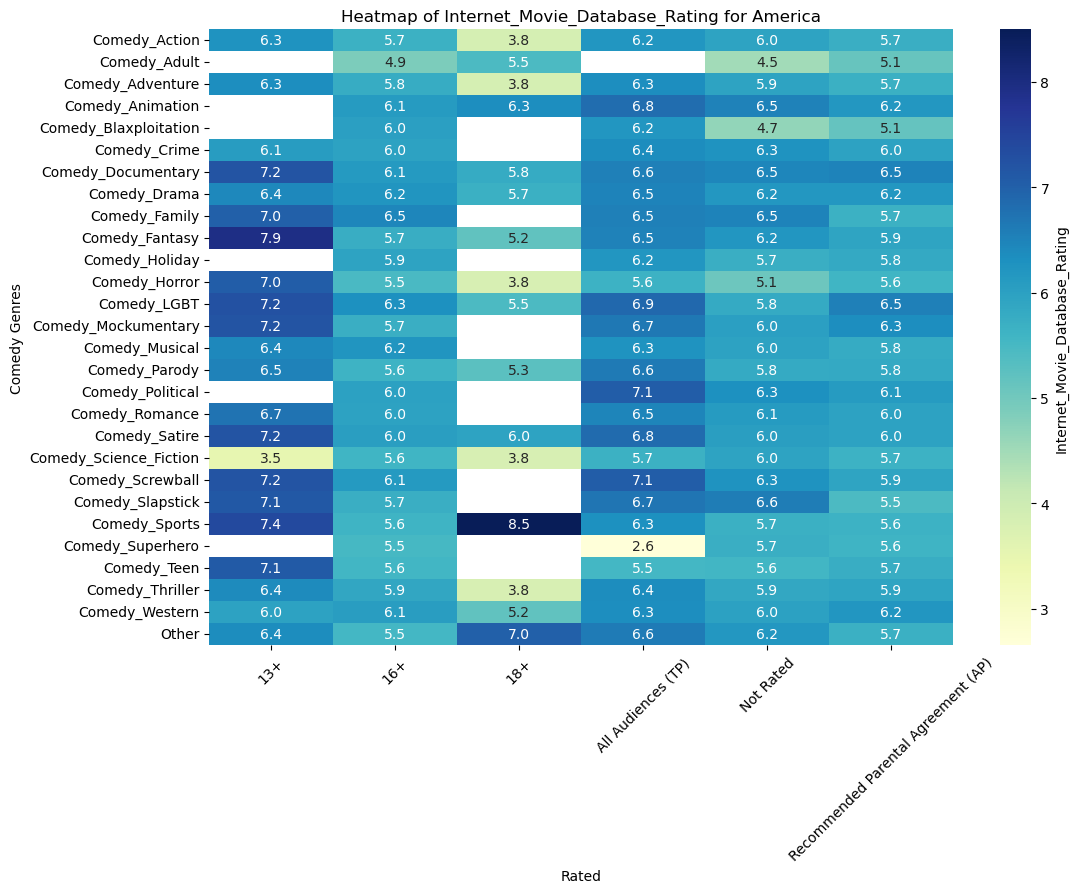

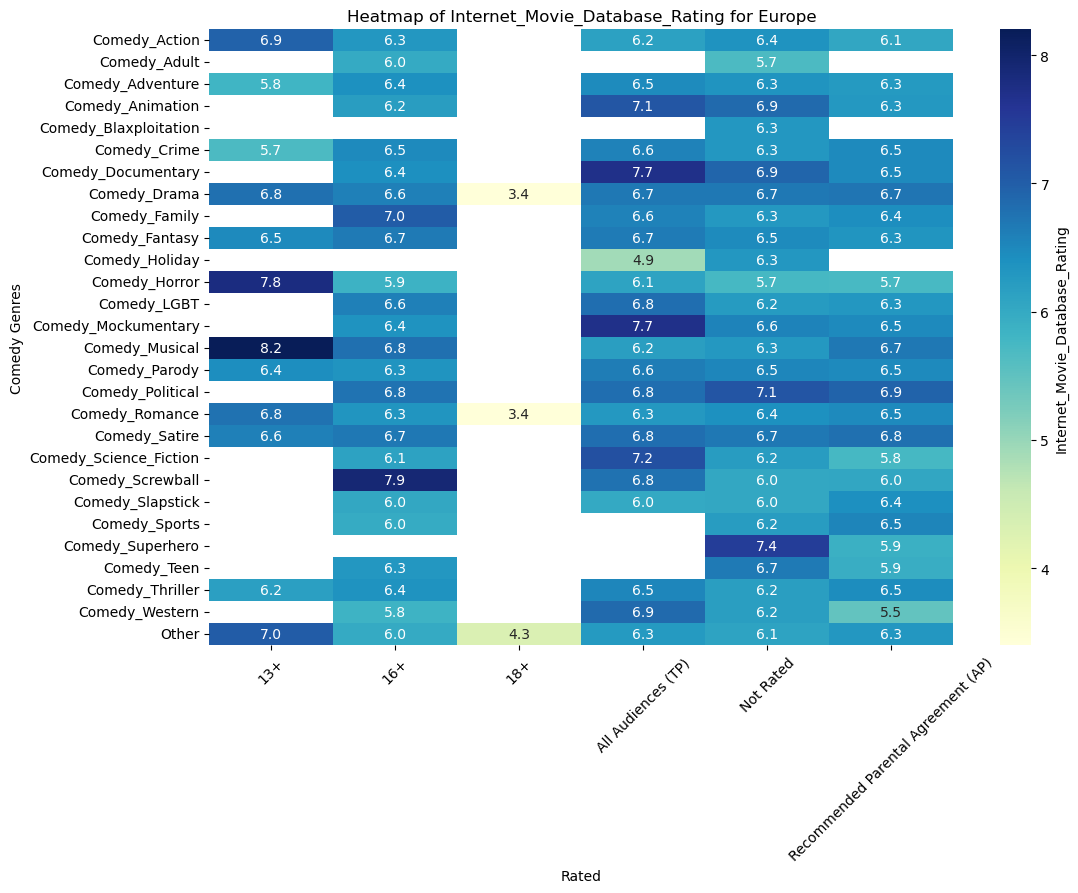

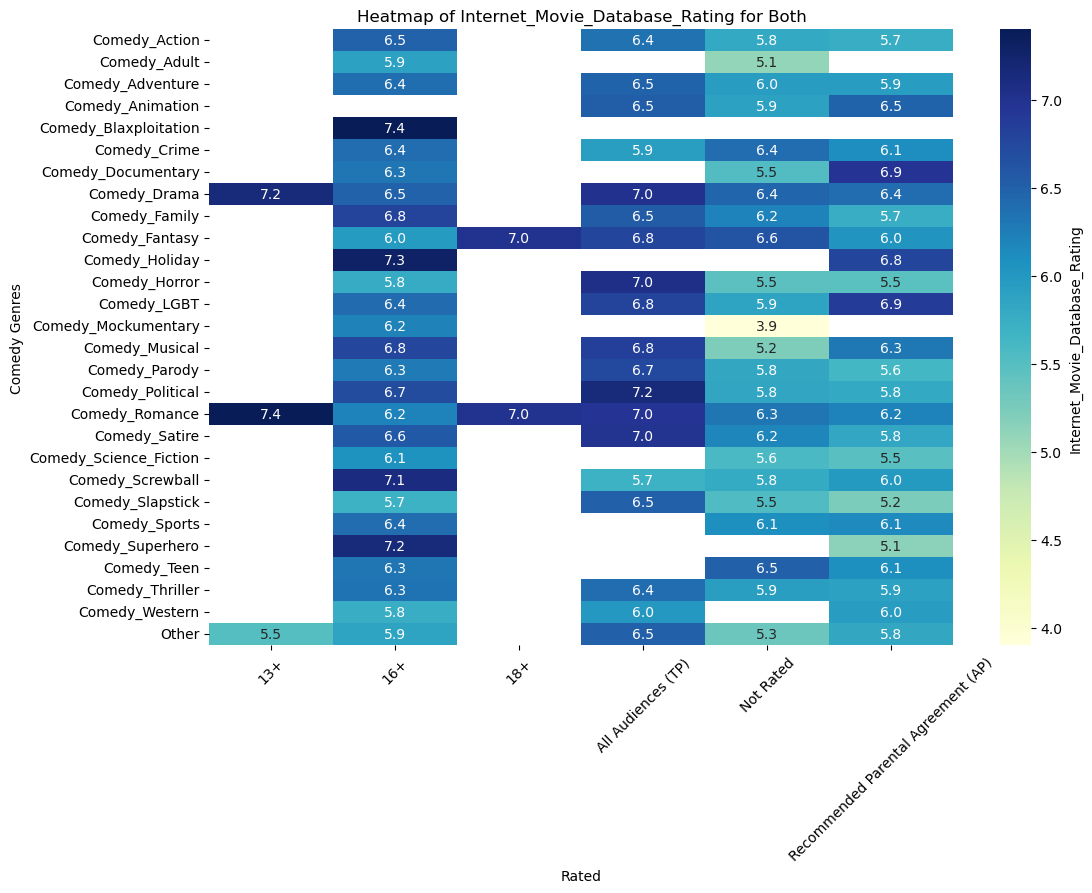

In [ ]:

# Function to create heatmap for a given continent
def create_heatmap(continent):
    # Filter data for the given continent
    continent_data = exploded_df[exploded_df['Continents'].apply(lambda x: continent in x)]
    
    # Group by comedy genres and rated, then calculate the mean box office revenue
    heatmap_data = continent_data.groupby(['comedy_genres', 'Rated'])['Internet_Movie_Database_Rating'].mean().unstack()
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Internet_Movie_Database_Rating'})
    plt.title(f'Heatmap of Internet_Movie_Database_Rating for {continent}')
    plt.xlabel('Rated')
    plt.ylabel('Comedy Genres')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Create heatmaps for each continent
for continent in ['America', 'Europe', 'Both']:
    create_heatmap(continent)

In [ ]:
# Explode the 'Types' column to have one type per row
exploded_dataset = dataset_Genre_Cleaned.explode('Types')


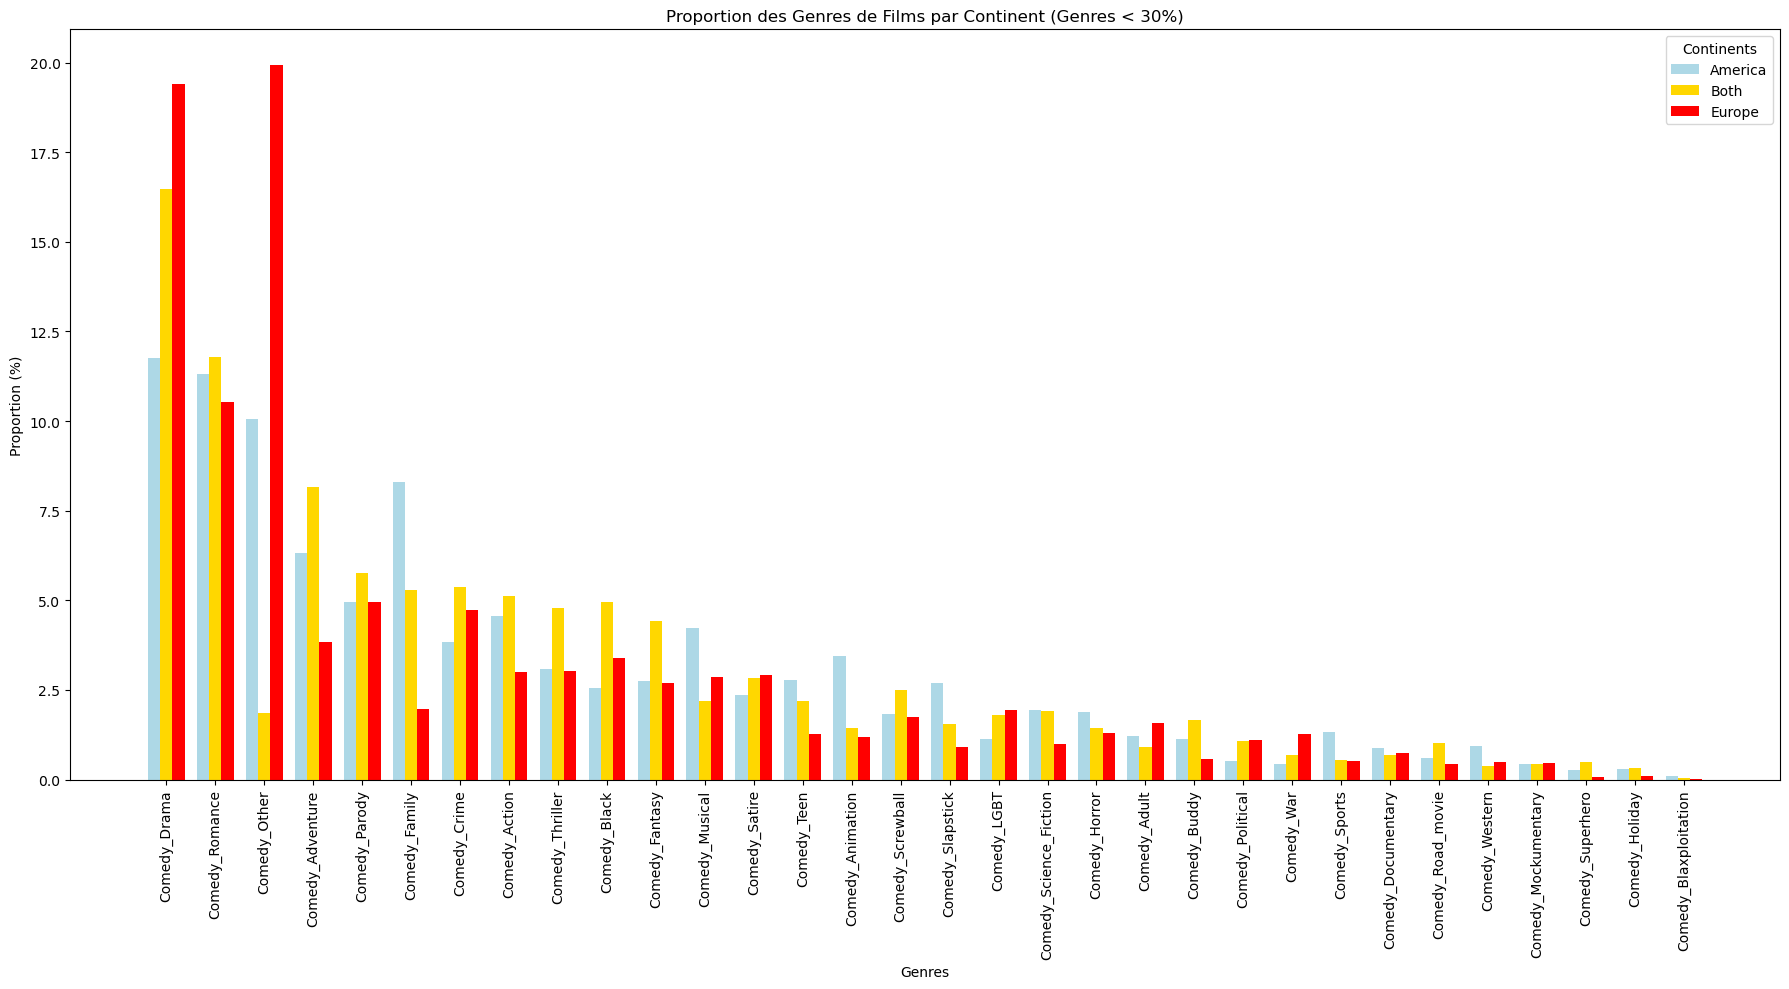

In [ ]:
# Calculer la proportion de chaque genre par continent
genre_proportion_by_continent = exploded_dataset.groupby(['Continents', 'Types']).size().unstack().apply(lambda x: x / x.sum(), axis=1) * 100

# Filtrer pour ne garder que les genres où chaque continent a moins de 10% de proportion
Pourcentage = 30
filtered_genre_proportion = genre_proportion_by_continent.loc[:, (genre_proportion_by_continent < Pourcentage).all()]

# Trier les genres par proportion totale décroissante
total_proportions = filtered_genre_proportion.sum(axis=0).sort_values(ascending=False)
filtered_genre_proportion = filtered_genre_proportion[total_proportions.index]

# Initialiser les couleurs pour chaque continent
colors = {
    'America': 'lightblue',
    'Both': 'gold',
    'Europe': 'red'
}

# Définir l'écart entre les barres
bar_width = 0.25
x = np.arange(len(filtered_genre_proportion.columns))  # Positions pour les genres filtrés

# Créer une figure pour les barres côte à côte
plt.figure(figsize=(18, 10))

# Tracer les barres pour chaque continent
for i, (continent, color) in enumerate(colors.items()):
    if continent in filtered_genre_proportion.index:
        # Décalage pour chaque continent
        plt.bar(x + i * bar_width, filtered_genre_proportion.loc[continent], width=bar_width, color=color, label=continent)

# Configurer les labels et le titre
plt.title('Proportion des Genres de Films par Continent (Genres < ' + str(Pourcentage) + '%)')
plt.xlabel('Genres')
plt.ylabel('Proportion (%)')
plt.xticks(x + bar_width, filtered_genre_proportion.columns, rotation=90)
plt.legend(title='Continents', loc='upper right')

plt.tight_layout()
plt.show()


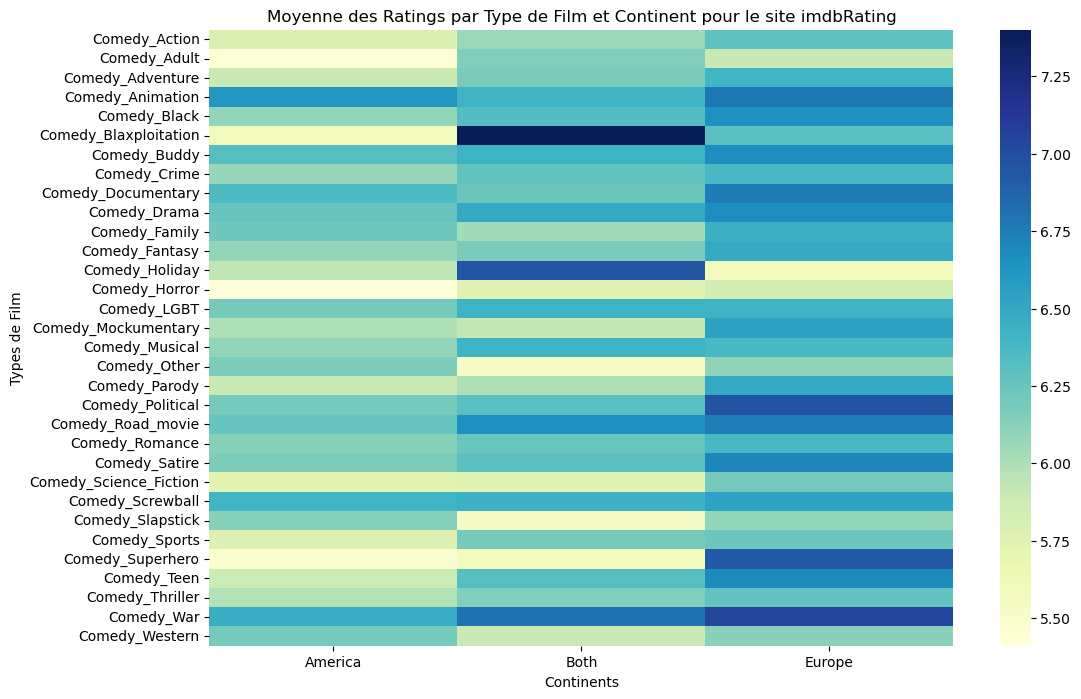

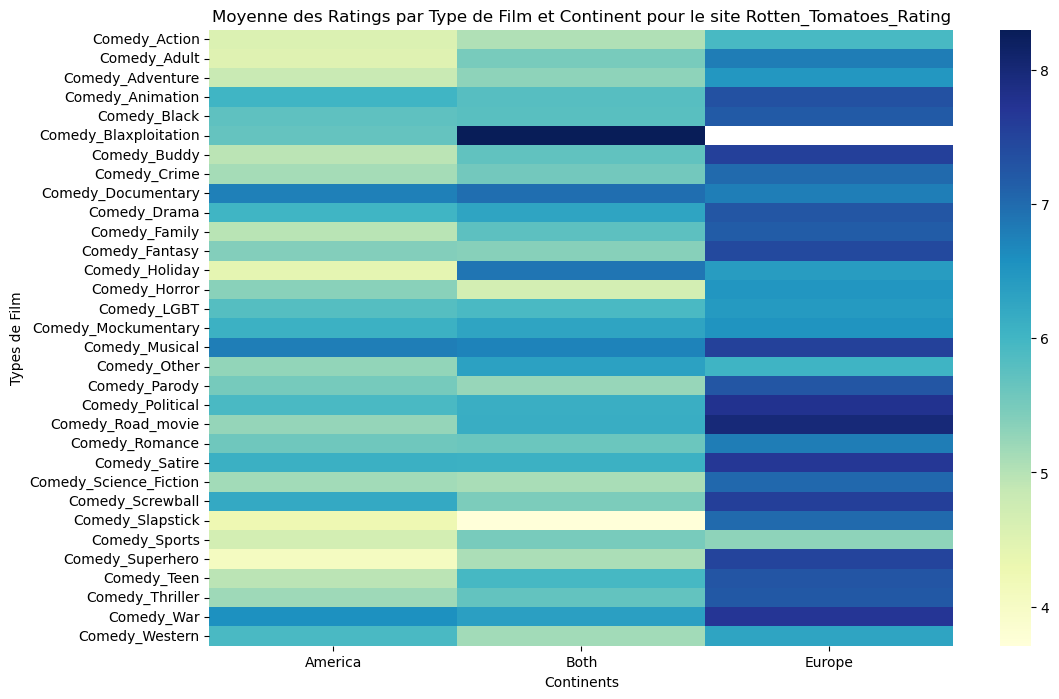

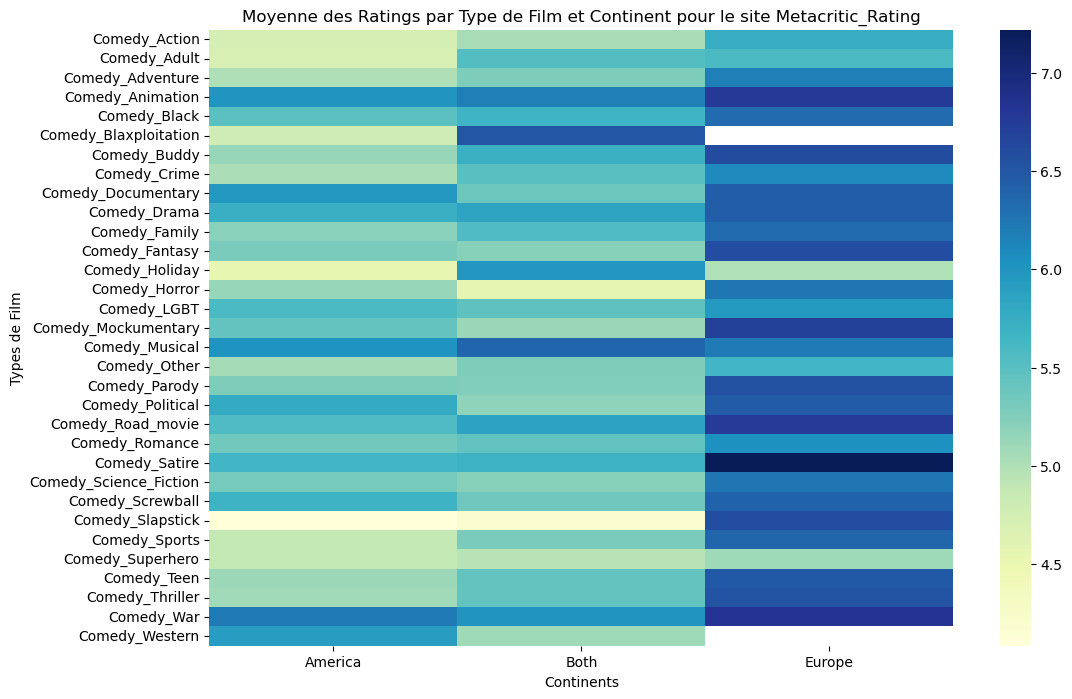

In [ ]:
for rating in ratings_columns:    
    
    # Now you can proceed with calculating the heatmap data based on 'Best_Rating'
    heatmap_data = exploded_dataset.groupby(['Types', 'Continents'])[rating].mean().unstack()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        #annot=True,
        cmap="YlGnBu",
        #fmt=".1f",
        #cbar_kws={'label': 'Average Rating'},
        #annot_kws={"color": "black"}
    )
    plt.title(f"Moyenne des Ratings par Type de Film et Continent pour le site {rating}")
    plt.xlabel("Continents")
    plt.ylabel("Types de Film")
    plt.show()